In [ ]:
'''
This notebook is used to analyse activities individually, based on a particular project (hence, a particular scenario over ther years).

'''

"\nThis notebook is used to analyse activities individually, based on a particular project (hence, a particular scenario over ther years).\n\nWe'll explore two scenarios here:\n\nBaseline (2020-2050) -> This will be a flat line, hey\nElectricity (2020-2050) -> We'll check the impacts based on a change in electricity demand respective to the Scenario (e.g. SSP1)\n"

# Libraries

In [69]:
# Import BW25 packages. You'll notice the packages are imported individually, unlike a one-and-done import with BW2.
import bw2data as bd
import bw2io as bi
import bw2calc as bc
import bw2analyzer as bwa
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
# import seaborn as sns
import pandas as pd

# 1. Support Functions

## 1.1. Functions

In [35]:
def search_and_get_exchanges(database, search_term):
    """
    Search for an activity in the database using the search term, 
    and return all exchanges for the first matching activity.

    Parameters:
    database: The Brightway2 database object to search within.
    search_term: The term to search for in the database.

    Returns:
    list: A list of exchanges for the first activity found using the search term.
    """
    # Perform the search
    search_results = database.search(search_term)
    
    # Get the first result
    if search_results:
        first_result = search_results[0]
        
        # Get all exchanges
        exchanges = list(first_result.exchanges())
        return exchanges
    else:
        return None


In [14]:
def filter_and_display_elementary_flows(exchanges):
    """
    Filters the exchanges to include only elementary flows and prints each one.

    Parameters:
    exchanges: A list of exchanges to filter.

    Returns:
    list: A list of elementary flows filtered from the exchanges.
    """
    # Filter for elementary flows
    elementary_flows = [ex for ex in exchanges if ex['type'] == 'biosphere']

    # Display the elementary flows
    for flow in elementary_flows:
        print(flow)
    
    return elementary_flows

In [ ]:
def find_activity_by_name_product_location(db_name, activity_name, reference_product=None, location=None):
    """
    Find an activity by name, reference product, and location in a given database.
    
    Parameters:
    - db_name: The name of the database to search.
    - activity_name: The name of the activity to search for.
    - reference_product: The reference product to filter the search (optional).
    - location: The location to filter the search (optional).
    
    Returns:
    - activity: The activity object found in the database.
    """
    db = bd.Database(db_name)
    search_results = db.search(activity_name)
    
    if not search_results:
        raise ValueError(f"Activity '{activity_name}' not found in database '{db_name}'")
    
    # Filter by reference product if provided
    if reference_product:
        search_results = [
            act for act in search_results if act['reference product'] == reference_product
        ]
        
        if not search_results:
            raise ValueError(f"No activity found with reference product '{reference_product}' for '{activity_name}'")
    
    # Filter by location if provided
    if location:
        search_results = [
            act for act in search_results if act['location'] == location
        ]
        
        if not search_results:
            raise ValueError(f"No activity found with location '{location}' for '{activity_name}' and '{reference_product}'")
    
    # Return the first match that has the correct filters applied
    return search_results[0]



In [58]:
def traverse_exchanges(activity, depth=0, max_depth=10, visited=None):
    """
    Recursively traverse the exchanges of an activity and its inputs.

    Parameters:
    - activity: The starting activity.
    - depth: Current depth of recursion.
    - max_depth: Maximum depth to explore.
    - visited: Set of visited activity keys to avoid cycles.
    """
    if visited is None:
        visited = set()
    indent = '  ' * depth
    activity_key = activity.key
    if activity_key in visited:
        print(f"{indent}Activity '{activity['name']}' ({activity['location']}) already visited. Skipping to avoid cycles.")
        return
    visited.add(activity_key)
    print(f"{indent}Activity: {activity['name']} ({activity['location']})")
    if depth >= max_depth:
        print(f"{indent}Maximum depth reached. Not exploring further.")
        return
    for exc in activity.exchanges():
        if exc['type'] == 'technosphere':
            input_activity = exc.input
            print(f"{indent}  Input: {input_activity['name']} ({input_activity['location']}) | Amount: {exc['amount']}")
            # Recursively explore inputs
            traverse_exchanges(input_activity, depth=depth+1, max_depth=max_depth, visited=visited)
        elif exc['type'] == 'biosphere':
            biosphere_flow = exc.input
            print(f"{indent}  Biosphere Flow: {biosphere_flow['name']} | Amount: {exc['amount']}")
        else:
            print(f"{indent}  Other Exchange: {exc.input} | Amount: {exc['amount']}")


In [ ]:
def run_comprehensive_lcia(activity, methods_list):
    """
    Perform a comprehensive LCIA for a given activity across multiple impact categories.
    
    Parameters:
    - activity: The specific activity for which the LCIA is to be performed.
    - methods_list: A list of tuples representing the impact assessment methods.

    Returns:
    - lca_results: A dictionary with methods as keys and their corresponding LCIA scores as values.
    """

    # Define the functional unit (e.g., 1 unit of the activity)
    functional_unit = {activity: 1}

    # Initialize a dictionary to store the results
    lca_results = defaultdict(float)

    # Loop over all impact categories in the method
    for method in methods_list:
        # Run LCI and LCIA
        lca = bc.LCA(functional_unit, method)
        lca.lci()
        lca.lcia()
        
        # Store the result for each category
        lca_results[method] = lca.score

    # Output the results
    for category, score in lca_results.items():
        print(f"{category}: {score}")
    
    return lca_results

In [18]:
def run_lcia_across_years(activity_name, methods_list, databases):
    """
    Run LCIA across multiple years (databases) and store results.
    
    Parameters:
    - activity_name: The name of the activity to analyze.
    - methods_list: A list of tuples representing the impact assessment methods.
    - databases: A list of database names (one for each year).
    
    Returns:
    - results_dict: A dictionary where keys are years and values are LCIA results dictionaries.
    """

    results_dict = {}

    for db_name in databases:
        # Set the current project
        bd.projects.set_current(project_name)

        try:
            # Find the specific activity in the current database
            activity = find_activity_by_name_product_location(db_name, activity_name)
        except ValueError as e:
            print(e)
            continue
    
        # Extract the year by finding the part that looks like a year

        # Urgently need to find a better way to do this:

        year = next(part for part in db_name.split('_') if part.isdigit() and len(part) == 4)

        # Run LCIA for the current year
        lca_results = run_comprehensive_lcia(activity, methods_list)

        # Store the results indexed by year
        results_dict[year] = lca_results

    return results_dict

In [19]:
def run_lcia_for_multiple_activities(activities, methods_list, databases):
    """
    Run LCIA across multiple years for multiple activities and store results.
    
    Parameters:
    - activities: A list of activity names to analyze.
    - methods_list: A list of tuples representing the impact assessment methods.
    - databases: A list of database names (one for each year).
    
    Returns:
    - results_dict: A nested dictionary where the first key is the activity name,
      the second key is the year, and the value is the LCIA results dictionary.
    """

    results_dict = {}

    for activity_name in activities:
        print(f"Processing activity: {activity_name}")
        lcia_results_per_year = run_lcia_across_years(activity_name, methods_list, databases)
        results_dict[activity_name] = lcia_results_per_year

    return results_dict

## 1.2. Visuals

In [20]:
def plot_lcia_results_across_years(results_dict, method):
    """
    Plot LCIA results for a specific impact category across multiple years.
    
    Parameters:
    - results_dict: A dictionary where keys are years and values are LCIA results dictionaries.
    - method: The specific impact category tuple to plot (e.g., ('ReCiPe Midpoint (H)', 'climate change', 'GWP100')).
    """

    years = sorted(results_dict.keys())
    scores = [results_dict[year][method] for year in years]

    plt.figure(figsize=(10, 6))
    plt.plot(years, scores, marker='o', linestyle='-', color='b')
    
    plt.xlabel('Year')
    plt.ylabel('Impact Score')
    plt.title(f'LCIA Results for {method[1]} ({method[2]}) across Years')
    
    plt.grid(True)
    plt.show()

In [21]:
def plot_all_lcia_results_across_years(lcia_results_per_year, methods_list):
    """
    Loop through all methods in the list and plot the LCIA results across years for each method.
    
    Parameters:
    - lcia_results_per_year: A dictionary where keys are years and values are LCIA results dictionaries.
    - methods_list: A list of tuples representing the impact assessment methods.
    """

    for method in methods_list:
        # Plot LCIA results for each method
        plot_lcia_results_across_years(lcia_results_per_year, method)

In [22]:
def plot_combined_lcia_results_across_years(lcia_results_per_year, methods_list, activity_name, project_name):
    """
    Plot all LCIA results for different methods across years into a single image using subplots.
    
    Parameters:
    - lcia_results_per_year: A dictionary where keys are years and values are LCIA results dictionaries.
    - methods_list: A list of tuples representing the impact assessment methods.
    - activity_name: The name of the activity being analyzed.
    - project_name: The name of the project.
    """

    num_methods = len(methods_list)
    num_cols = 3  # Number of columns for subplots
    num_rows = (num_methods + num_cols - 1) // num_cols  # Calculate the number of rows needed

    plt.figure(figsize=(15, 5 * num_rows))

    for i, method in enumerate(methods_list, 1):
        years = sorted(lcia_results_per_year.keys())
        scores = [lcia_results_per_year[year][method] for year in years]

        plt.subplot(num_rows, num_cols, i)
        plt.plot(years, scores, marker='o', linestyle='-', color='b')

        plt.xlabel('Year')
        plt.ylabel('Impact Score')
        plt.title(f'{method[1]} ({method[2]})')

        plt.grid(True)

    # Add a main title that includes the activity name and project name
    plt.suptitle(f'LCIA Results for {activity_name}\nProject: {project_name}', fontsize=16, y=1.02)

    plt.tight_layout()
    plt.show()

In [23]:
def plot_comparison_across_activities(results_dict, methods_list, activities):
    """
    Plot comparison of LCIA results across activities for each impact category,
    with a single, wrapping legend at the bottom of the figure.
    
    Parameters:
    - results_dict: A nested dictionary with LCIA results for all activities and years.
    - methods_list: A list of tuples representing the impact assessment methods.
    - activities: A list of activity names that were analyzed.
    """

    num_methods = len(methods_list)
    num_cols = 3  # Number of columns for subplots
    num_rows = (num_methods + num_cols - 1) // num_cols  # Calculate the number of rows needed

    plt.figure(figsize=(15, 5 * num_rows))

    for i, method in enumerate(methods_list, 1):
        plt.subplot(num_rows, num_cols, i)
        for activity_name in activities:
            years = sorted(results_dict[activity_name].keys())
            scores = [results_dict[activity_name][year][method] for year in years]

            plt.plot(years, scores, marker='o', linestyle='-', label=activity_name)

        plt.xlabel('Year')
        plt.ylabel('Impact Score')
        plt.title(f'{method[1]} ({method[2]})')

        plt.grid(True)

    # Add a wrapping legend for all plots at the bottom
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.figlegend(handles, labels, loc='upper center', ncol=1, fontsize='large')

    plt.suptitle(f'Comparison of LCIA Results Across Activities\nProject: SSP1-Base', fontsize=16, y=1.02)
    plt.tight_layout()  # Adjust layout to make space for the legend at the bottom
    plt.show()

## 1.3. Lists

In [24]:
# List of ReCiPe Midpoint (H)
# H stands for Hierarchist
## https://www.rivm.nl/bibliotheek/rapporten/2016-0104.pdf
recipe_midpoint_h = [
    ('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'),
    ('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'),
    ('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'),
    ('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'),
    ('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'),
    ('ReCiPe Midpoint (H)', 'climate change', 'GWP100'),
    ('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'),
    ('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'),
    ('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'),
    ('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'),
    ('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'),
    ('ReCiPe Midpoint (H)', 'water depletion', 'WDP'),
    ('ReCiPe Midpoint (H)', 'urban land occupation', 'ULOP'),
    ('ReCiPe Midpoint (H)', 'ionising radiation', 'IRP_HE'),
    ('ReCiPe Midpoint (H)', 'fossil depletion', 'FDP'),
    ('ReCiPe Midpoint (H)', 'freshwater ecotoxicity', 'FETPinf'),
    ('ReCiPe Midpoint (H)', 'marine ecotoxicity', 'METPinf'),
    ('ReCiPe Midpoint (H)', 'ozone depletion', 'ODPinf')
]

In [25]:
recipe_endpoint_h_a = [
    ('ReCiPe Endpoint (H,A)', 'human health', 'total'),
    ('ReCiPe Endpoint (H,A)', 'ecosystem quality', 'total'),
    ('ReCiPe Endpoint (H,A)', 'resources', 'total')
]

In [26]:
databases_remindSSP1_baseline = [
 'EI38_cutoff_remind_SSP1-Base_2020_baseline',
 'EI38_cutoff_remind_SSP1-Base_2025_baseline',
 'EI38_cutoff_remind_SSP1-Base_2030_baseline',
 'EI38_cutoff_remind_SSP1-Base_2035_baseline',
 'EI38_cutoff_remind_SSP1-Base_2040_baseline',
 'EI38_cutoff_remind_SSP1-Base_2045_baseline',
 'EI38_cutoff_remind_SSP1-Base_2050_baseline'
]

databases_remindSSP1_VSI_test_1 = [
 'EI38_cutoff_remind_SSP1-Base_2020_VSI_test_1',
 'EI38_cutoff_remind_SSP1-Base_2025_VSI_test_1',
 'EI38_cutoff_remind_SSP1-Base_2030_VSI_test_1',
 'EI38_cutoff_remind_SSP1-Base_2035_VSI_test_1',
 'EI38_cutoff_remind_SSP1-Base_2040_VSI_test_1',
 'EI38_cutoff_remind_SSP1-Base_2045_VSI_test_1',
 'EI38_cutoff_remind_SSP1-Base_2050_VSI_test_1' 
]

databases_remindSSP1_energy = [
 'EI38_cutoff_remind_SSP1-Base_2020_energy',
 'EI38_cutoff_remind_SSP1-Base_2025_energy',
 'EI38_cutoff_remind_SSP1-Base_2030_energy',
 'EI38_cutoff_remind_SSP1-Base_2035_energy',
 'EI38_cutoff_remind_SSP1-Base_2040_energy',
 'EI38_cutoff_remind_SSP1-Base_2045_energy',
 'EI38_cutoff_remind_SSP1-Base_2050_energy' 
]

databases_remindSSP1_energy_and_VSI_test_1 = [
 'EI38_cutoff_remind_SSP1-Base_2020_energy_and_VSI_test_1',
 'EI38_cutoff_remind_SSP1-Base_2025_energy_and_VSI_test_1',
 'EI38_cutoff_remind_SSP1-Base_2030_energy_and_VSI_test_1',
 'EI38_cutoff_remind_SSP1-Base_2035_energy_and_VSI_test_1',
 'EI38_cutoff_remind_SSP1-Base_2040_energy_and_VSI_test_1',
 'EI38_cutoff_remind_SSP1-Base_2045_energy_and_VSI_test_1',
 'EI38_cutoff_remind_SSP1-Base_2050_energy_and_VSI_test_1' 
]


In [28]:
activities_li = [
    ('lithium carbonate production, from concentrated brine', 'GLO'),
    ('lithium carbonate production, from spodumene', 'RoW'),
    ('lithium carbonate production, from spodumene', 'CN')
]

reference_product_lithium = 'lithium carbonate'

activities_ni = [
    ('treatment of metal part of electronics scrap, in copper, anode, by electrolytic refining', 'RoW'),
    ('platinum group metal mine operation, ore with high palladium content', 'RU'),
    ('platinum group metal, extraction and refinery operations', 'ZA'),
    ('processing of nickel-rich materials', 'GLO'),
    ('smelting and refining of nickel concentrate, 16% Ni', 'GLO'),
    ('smelting and refining of nickel concentrate, 7% Ni', 'CN'),
    ('treatment of metal part of electronics scrap, in copper, anode, by electrolytic refining', 'SE'),
    ('cobalt production', 'GLO')
]

reference_product_nickel = 'nickel, class 1'

activities_mn = [
    ('manganese dioxide production', 'GLO'),
    ('manganese sulfate production', 'GLO')
]

reference_product_manganese = 'manganese sulfate'

# 2. Imports and Declarations

In [40]:
project_name = "test-EI38-SSP1-Base"
#Creating/accessing the project
bd.projects.set_current(project_name)

In [41]:
bd.databases

Databases dictionary with 30 objects, including:
	EI38_cutoff_remind_SSP1-Base_2020_VSI_test_1
	EI38_cutoff_remind_SSP1-Base_2020_baseline
	EI38_cutoff_remind_SSP1-Base_2020_energy
	EI38_cutoff_remind_SSP1-Base_2020_energy_and_VSI_test_1
	EI38_cutoff_remind_SSP1-Base_2025_VSI_test_1
	EI38_cutoff_remind_SSP1-Base_2025_baseline
	EI38_cutoff_remind_SSP1-Base_2025_energy
	EI38_cutoff_remind_SSP1-Base_2025_energy_and_VSI_test_1
	EI38_cutoff_remind_SSP1-Base_2030_VSI_test_1
	EI38_cutoff_remind_SSP1-Base_2030_baseline
Use `list(this object)` to get the complete list.

In [52]:
# Accessing the SSP1 2020 database
db_name = 'EI38_cutoff_remind_SSP1-Base_2020_energy'
db = bd.Database('EI38_cutoff_remind_SSP1-Base_2020_energy')

# 3. Lithium Carbonate

In [46]:
'''
The ecoinvent 3.8 database has an activity "market for lithium carbonate".
Such activity feeds from:
- lithium carbonate production, from spodumene (CN)
- lithium carbonate production, from spodumene (RoW)
- lithium carbonate production, from concentrated brine (GLO)
- treatment of used Li-ion battery, hydrometallurgical treatment (GLO)
- [ ... ]  Other activities
When applying the PREMISE2.0 SSP1-Base update based on energy, we get a new activity:
- market for lithium hydroxide, battery grade
'''

'\nThe ecoinvent 3.8 database has an activity "market for lithium carbonate".\nSuch activity feeds from:\n- lithium carbonate production, from spodumene (CN)\n- lithium carbonate production, from spodumene (RoW)\n- lithium carbonate production, from concentrated brine (GLO)\n- treatment of used Li-ion battery, hydrometallurgical treatment (GLO)\n- [ ... ]  Other activities\nWhen applying the PREMISE2.0 SSP1-Base update based on energy, we get a new activity:\n- market for lithium hydroxide, battery grade\n'

## 3.1. LiO2 production, battery grade

In [33]:
# Search term from updated SSP1-Base2020 database.
# Updated from:
## Source: Jarod C. Kelly, Michael Wang, Qiang Dai, Olumide Winjobi, Energy, greenhouse gas, and water life cycle analysis of lithium carbonate and lithium hydroxide monohydrate from brine and ore resources and their use in lithium ion battery cathodes and lithium ion batteries, Resources, Conservation and Recycling, Volume 174, 2021, 105762, ISSN 0921-3449, https://doi.org/10.1016/j.resconrec.2021.105762.

search_term = "lithium hydroxide production, battery grade"
reference_product = reference_product_lithium

In [44]:
db_name.search(search_term)

['lithium hydroxide production, battery grade' (kilogram, GLO, None),
 'market for lithium hydroxide, battery grade' (kilogram, GLO, None)]

In [51]:
activity = find_activity_by_name_product(db_name, search_term)

In [53]:
exchanges = search_and_get_exchanges(db, search_term)
exchanges

[Exchange: 1.0 kilogram 'lithium hydroxide production, battery grade' (kilogram, GLO, None) to 'lithium hydroxide production, battery grade' (kilogram, GLO, None)>,
 Exchange: 0.6042129327237098 kilogram 'lithium carbonate production, from Salar de Atacama' (kilogram, CL, None) to 'lithium hydroxide production, battery grade' (kilogram, GLO, None)>,
 Exchange: 0.08229915088177661 kilogram 'lithium carbonate production, from Salar de Olaroz' (kilogram, AR, None) to 'lithium hydroxide production, battery grade' (kilogram, GLO, None)>,
 Exchange: 0.2743305029392557 kilogram 'lithium carbonate production, from Salar de Cauchari-Olaroz' (kilogram, AR, None) to 'lithium hydroxide production, battery grade' (kilogram, GLO, None)>,
 Exchange: 0.034291312867406915 kilogram 'lithium carbonate production, from Salar del Hombre Muerto' (kilogram, AR, None) to 'lithium hydroxide production, battery grade' (kilogram, GLO, None)>,
 Exchange: 0.05486610058785104 kilogram 'lithium carbonate production,

In [54]:
elementary_flows = filter_and_display_elementary_flows(exchanges)

Exchange: 0.0005 cubic meter 'Water, unspecified natural origin' (cubic meter, None, ('natural resource', 'in ground')) to 'lithium hydroxide production, battery grade' (kilogram, GLO, None)>
Exchange: 0.0001 kilogram 'Particulates, > 2.5 um, and < 10um' (kilogram, None, ('air',)) to 'lithium hydroxide production, battery grade' (kilogram, GLO, None)>
Exchange: 5e-05 kilogram 'Particulates, < 2.5 um' (kilogram, None, ('air',)) to 'lithium hydroxide production, battery grade' (kilogram, GLO, None)>


In [50]:
'''
Let's explore the activiies:
'lithium carbonate production, from Salar de Atacama'
'lithium carbonate production, from Salar de Olaroz'
'lithium carbonate production, from Salar de Cauchari-Olaroz'
'lithium carbonate production, from Salar del Hombre Muerto'
'lithium carbonate production, from Chaerhan salt lake'
'''

"\nLet's explore the activiies:\n'lithium carbonate production, from Salar de Atacama'\n'lithium carbonate production, from Salar de Olaroz'\n'lithium carbonate production, from Salar de Cauchari-Olaroz'\n'lithium carbonate production, from Salar del Hombre Muerto'\n'lithium carbonate production, from Chaerhan salt lake'\n"

### 3.1.1. lithium carbonate production, from Salar de Atacama

#### 3.1.1.1. Getting activity and travesing inventory

In [59]:
# Search term from updated SSP1-Base2020 database.
# Updated from:
## Source: Jarod C. Kelly, Michael Wang, Qiang Dai, Olumide Winjobi, Energy, greenhouse gas, and water life cycle analysis of lithium carbonate and lithium hydroxide monohydrate from brine and ore resources and their use in lithium ion battery cathodes and lithium ion batteries, Resources, Conservation and Recycling, Volume 174, 2021, 105762, ISSN 0921-3449, https://doi.org/10.1016/j.resconrec.2021.105762.
activity_name = 'lithium carbonate production, from Salar de Atacama'
activity = find_activity_by_name_product(db_name, activity_name)

In [60]:
# To view the inventory
for exc in activity.exchanges():
    print(f"Input: {exc.input} | Amount: {exc['amount']}")

Input: 'lithium carbonate production, from Salar de Atacama' (kilogram, CL, None) | Amount: 1.0
Input: 'lithium carbonate precipitation 2' (kilogram, CL, None) | Amount: 27.223366499999994
Input: 'heat production, natural gas, at industrial furnace >100kW' (megajoule, RoW, None) | Amount: 3.0
Input: 'market group for electricity, high voltage' (kilowatt hour, LAM, None) | Amount: 0.3310672137551645


In [66]:
bwa.print_recursive_supply_chain(activity, max_level=3, cutoff=0.03)

1: 'lithium carbonate production, from Salar de Atacama' (kilogram, CL, N
  27.2: 'lithium carbonate precipitation 2' (kilogram, CL, None)
    27.5: 'filtering, through water ion exchanger' (kilogram, CL, None)
    2: 'lithium carbonate washing' (kilogram, CL, None)
      34: 'lithium carbonate precipitation 1' (kilogram, CL, None)
      2: 'filtering, through water ion exchanger' (kilogram, CL, None)
      0.99: 'heat production, natural gas, at industrial furnace >100kW' (megajoul
      0.0361: 'market group for electricity, high voltage' (kilowatt hour, LAM, None
    15.9: 'heat production, natural gas, at industrial furnace >100kW' (megajoul
      0.124: 'market for natural gas, high pressure' (cubic meter, US, None)
      0.285: 'market for natural gas, high pressure' (cubic meter, RoW, None)
  3: 'heat production, natural gas, at industrial furnace >100kW' (megajoul
    0.0539: 'market for natural gas, high pressure' (cubic meter, RoW, None)
  0.331: 'market group for electricity

In [61]:
# Traverse the exchanges up to a desired depth (e.g., max_depth=2)
traverse_exchanges(activity, max_depth=5)

Activity: lithium carbonate production, from Salar de Atacama (CL)
  Other Exchange: 'lithium carbonate production, from Salar de Atacama' (kilogram, CL, None) | Amount: 1.0
  Input: lithium carbonate precipitation 2 (CL) | Amount: 27.223366499999994
  Activity: lithium carbonate precipitation 2 (CL)
    Other Exchange: 'lithium carbonate precipitation 2' (kilogram, CL, None) | Amount: 1.0
    Input: filtering, through water ion exchanger (CL) | Amount: 1.008954333269008
    Activity: filtering, through water ion exchanger (CL)
      Other Exchange: 'filtering, through water ion exchanger' (kilogram, CL, None) | Amount: 1.0
      Biosphere Flow: Water, unspecified natural origin | Amount: 0.001
      Input: market group for electricity, high voltage (LAM) | Amount: 0.00082
      Activity: market group for electricity, high voltage (LAM)
        Other Exchange: 'market group for electricity, high voltage' (kilowatt hour, LAM, None) | Amount: 1.0
        Input: market group for electrici

In [85]:
def collect_exchanges(activity, depth=0, max_depth=5, visited=None, data=None):
    """
    Recursively traverse the exchanges of an activity and its inputs,
    collecting data into a list of exchanges.

    Parameters:
    - activity: The starting activity.
    - depth: Current depth of recursion.
    - max_depth: Maximum depth to explore.
    - visited: Set of visited activity keys to avoid cycles.
    - data: List to collect the data.

    Returns:
    - data: A list of dictionaries containing exchange information.
    """
    if visited is None:
        visited = set()
    if data is None:
        data = []
    activity_key = activity.key
    if activity_key in visited:
        return data
    visited.add(activity_key)

    if depth >= max_depth:
        return data

    for exc in activity.exchanges():
        if exc['type'] == 'technosphere':
            input_activity = exc.input
            # Collect data about the exchange
            data.append({
                'depth': depth + 1,
                'from_activity_name': activity['name'],
                'from_activity_location': activity['location'],
                'from_reference_product': activity.get('reference product', ''),
                'from_unit': activity.get('unit', ''),
                'from_activity_type': activity.get('type', ''),
                'to_activity_name': input_activity['name'],
                'to_activity_location': input_activity['location'],
                'to_reference_product': input_activity.get('reference product', ''),
                'to_unit': input_activity.get('unit', ''),
                'to_activity_type': input_activity.get('type', ''),
                'amount': exc['amount'],
                'exchange_type': exc['type'],
            })
            # Recursively explore inputs
            collect_exchanges(input_activity, depth=depth+1, max_depth=max_depth, visited=visited, data=data)
        elif exc['type'] == 'biosphere':
            biosphere_flow = exc.input
            # Collect data about the biosphere flow
            data.append({
                'depth': depth + 1,
                'from_activity_name': activity['name'],
                'from_activity_location': activity['location'],
                'from_reference_product': activity.get('reference product', ''),
                'from_unit': activity.get('unit', ''),
                'from_activity_type': activity.get('type', ''),
                'to_activity_name': biosphere_flow['name'],
                'to_activity_location': biosphere_flow.get('location', ''),
                'to_reference_product': '',
                'to_unit': biosphere_flow.get('unit', ''),
                'to_activity_type': 'biosphere',
                'amount': exc['amount'],
                'exchange_type': exc['type'],
            })
        else:
            # Handle other exchange types if necessary
            pass

    return data

In [93]:
# Collect exchanges data with desired max depth
exchanges_data = collect_exchanges(activity, max_depth=3)

# Convert the data to a DataFrame
exchanges_df = pd.DataFrame(exchanges_data)

In [94]:
exchanges_df

depth                                 from_activity_name  \
0       1  lithium carbonate production, from Salar de At...   
1       2                  lithium carbonate precipitation 2   
2       3             filtering, through water ion exchanger   
3       3             filtering, through water ion exchanger   
4       2                  lithium carbonate precipitation 2   
5       3                          lithium carbonate washing   
6       3                          lithium carbonate washing   
7       3                          lithium carbonate washing   
8       3                          lithium carbonate washing   
9       2                  lithium carbonate precipitation 2   
10      1  lithium carbonate production, from Salar de At...   
11      1  lithium carbonate production, from Salar de At...   

   from_activity_location                  from_reference_product from_unit  \
0                      CL        lithium carbonate, battery grade  kilogram   
1                      CL         lithium carbonate, precipitated  kilogram   
2                      CL  filtering, through water ion exchanger  kilogram   
3                      CL  filtering, through water ion exchanger  kilogram   
4                      CL         lithium carbonate, precipitated  kilogram   
5                      CL               lithium carbonate, washed  kilogram   
6                      CL               lithium carbonate, washed  kilogram   
7                      CL               lithium carbonate, washed  kilogram   
8                      CL               lithium carbonate, washed  kilogram   
9                      CL         lithium carbonate, precipitated  kilogram   
10                     CL        lithium carbonate, battery grade  kilogram   
11                     CL        lithium carbonate, battery grade  kilogram   

   from_activity_type                                   to_activity_name  \
0                                      lithium carbonate precipitation 2   
1                                 filtering, through water ion exchanger   
2                                      Water, unspecified natural origin   
3                             market group for electricity, high voltage   
4                                              lithium carbonate washing   
5                                      lithium carbonate precipitation 1   
6                                 filtering, through water ion exchanger   
7                      heat production, natural gas, at industrial fu...   
8                             market group for electricity, high voltage   
9                      heat production, natural gas, at industrial fu...   
10                     heat production, natural gas, at industrial fu...   
11                            market group for electricity, high voltage   

   to_activity_location                       to_reference_product  \
0                    CL            lithium carbonate, precipitated   
1                    CL     filtering, through water ion exchanger   
2                                                                    
3                   LAM                  electricity, high voltage   
4                    CL                  lithium carbonate, washed   
5                    CL            lithium carbonate, precipitated   
6                    CL     filtering, through water ion exchanger   
7                   RoW  heat, district or industrial, natural gas   
8                   LAM                  electricity, high voltage   
9                   RoW  heat, district or industrial, natural gas   
10                  RoW  heat, district or industrial, natural gas   
11                  LAM                  electricity, high voltage   

          to_unit to_activity_type     amount exchange_type  
0        kilogram                   27.223366  technosphere  
1        kilogram                    1.008954  technosphere  
2     cubic meter        biosphere   0.001000     biosphe

In [95]:
exchanges_df.to_csv('exchanges_data.csv', index=False)

In [26]:
# Run the LCIA across all years
lcia_results_per_year = run_lcia_across_years(activity_name, recipe_midpoint_h, databases_remindSSP1_energy)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.0003329566962788494
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.0013366815263864352
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.00861088992773888
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 1.0070318590116354
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.0026960593978378224
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 3.185952325892311
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.004558360033071338
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.25974508904597476
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.0006471257903494071
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 0.21038896775542384
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.014924496742181052
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.003889666924204115
('ReCiPe Midpoint (H)', 'urban land o

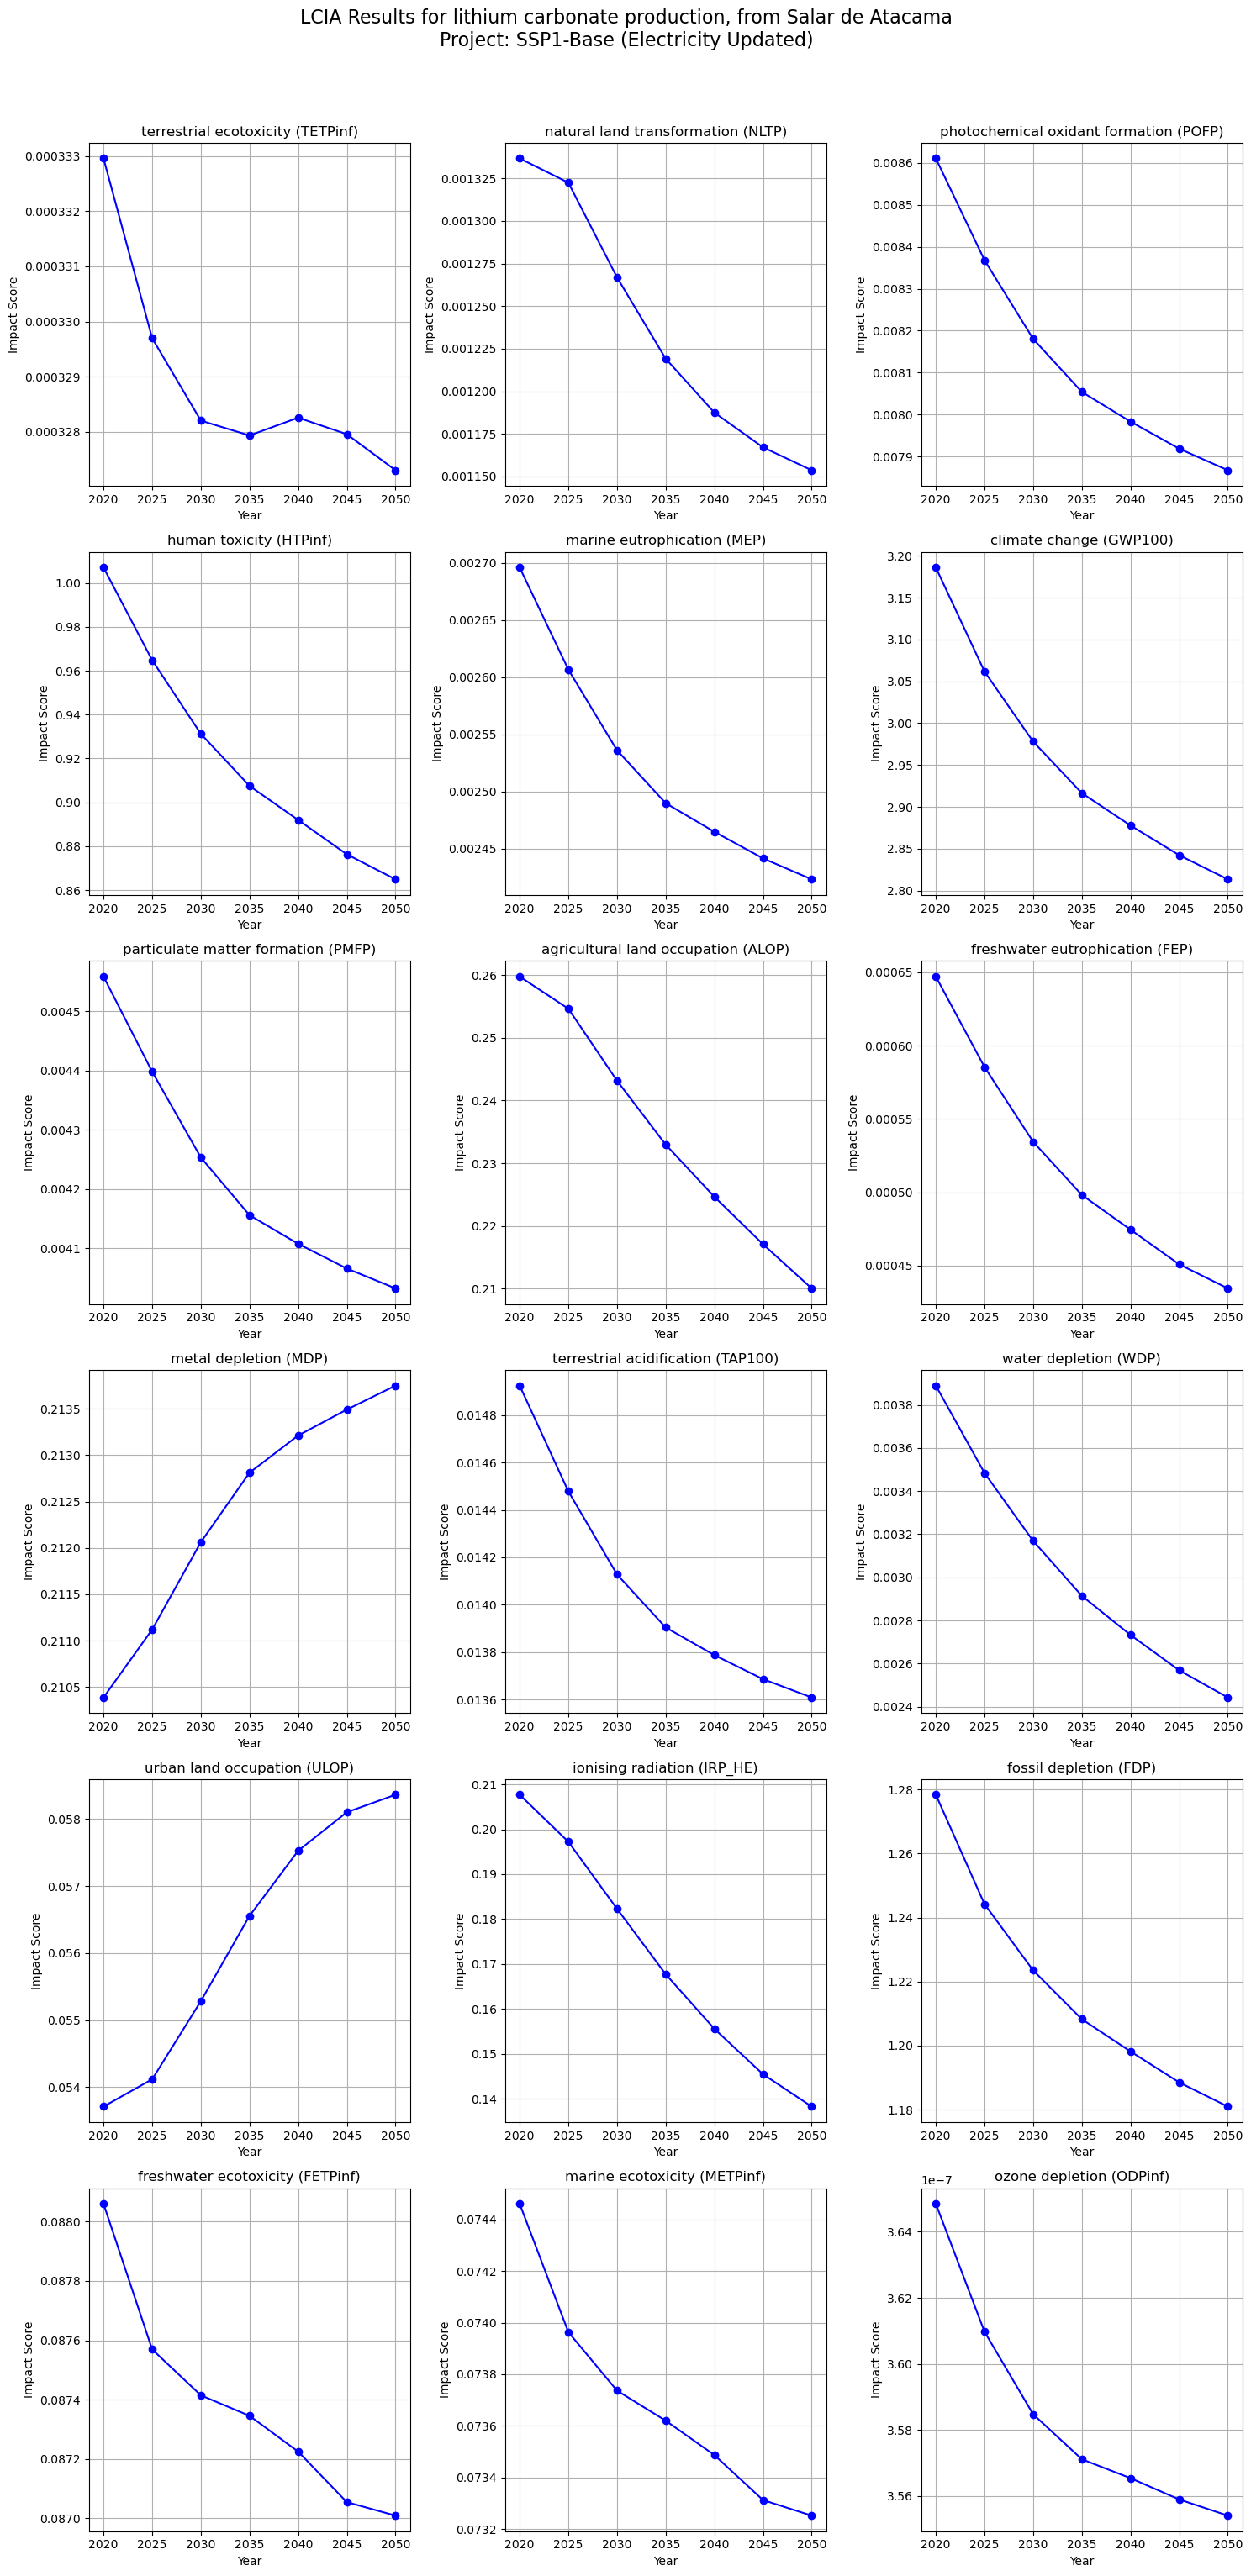

In [27]:
plot_combined_lcia_results_across_years(lcia_results_per_year, recipe_midpoint_h, activity_name, "SSP1-Base (Electricity Updated)")

### 1.1.2. lithium carbonate production, from Salar de Olaroz

In [28]:
# Search term from updated SSP1-Base2020 database.
# Updated from:
## Source: Jarod C. Kelly, Michael Wang, Qiang Dai, Olumide Winjobi, Energy, greenhouse gas, and water life cycle analysis of lithium carbonate and lithium hydroxide monohydrate from brine and ore resources and their use in lithium ion battery cathodes and lithium ion batteries, Resources, Conservation and Recycling, Volume 174, 2021, 105762, ISSN 0921-3449, https://doi.org/10.1016/j.resconrec.2021.105762.
activity_name = 'lithium carbonate production, from Salar de Olaroz'

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.015449850199049693
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.0014233348685918096
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.012159399802309354
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 7.863131779375817
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.0035622359351797995
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 6.966649488806558
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.005513823529859949
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.3908294928586622
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.00060124280892453
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 0.16628417867358403
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.015137660816324483
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.005125877745361834
('ReCiPe Midpoint (H)', 'urban land occup

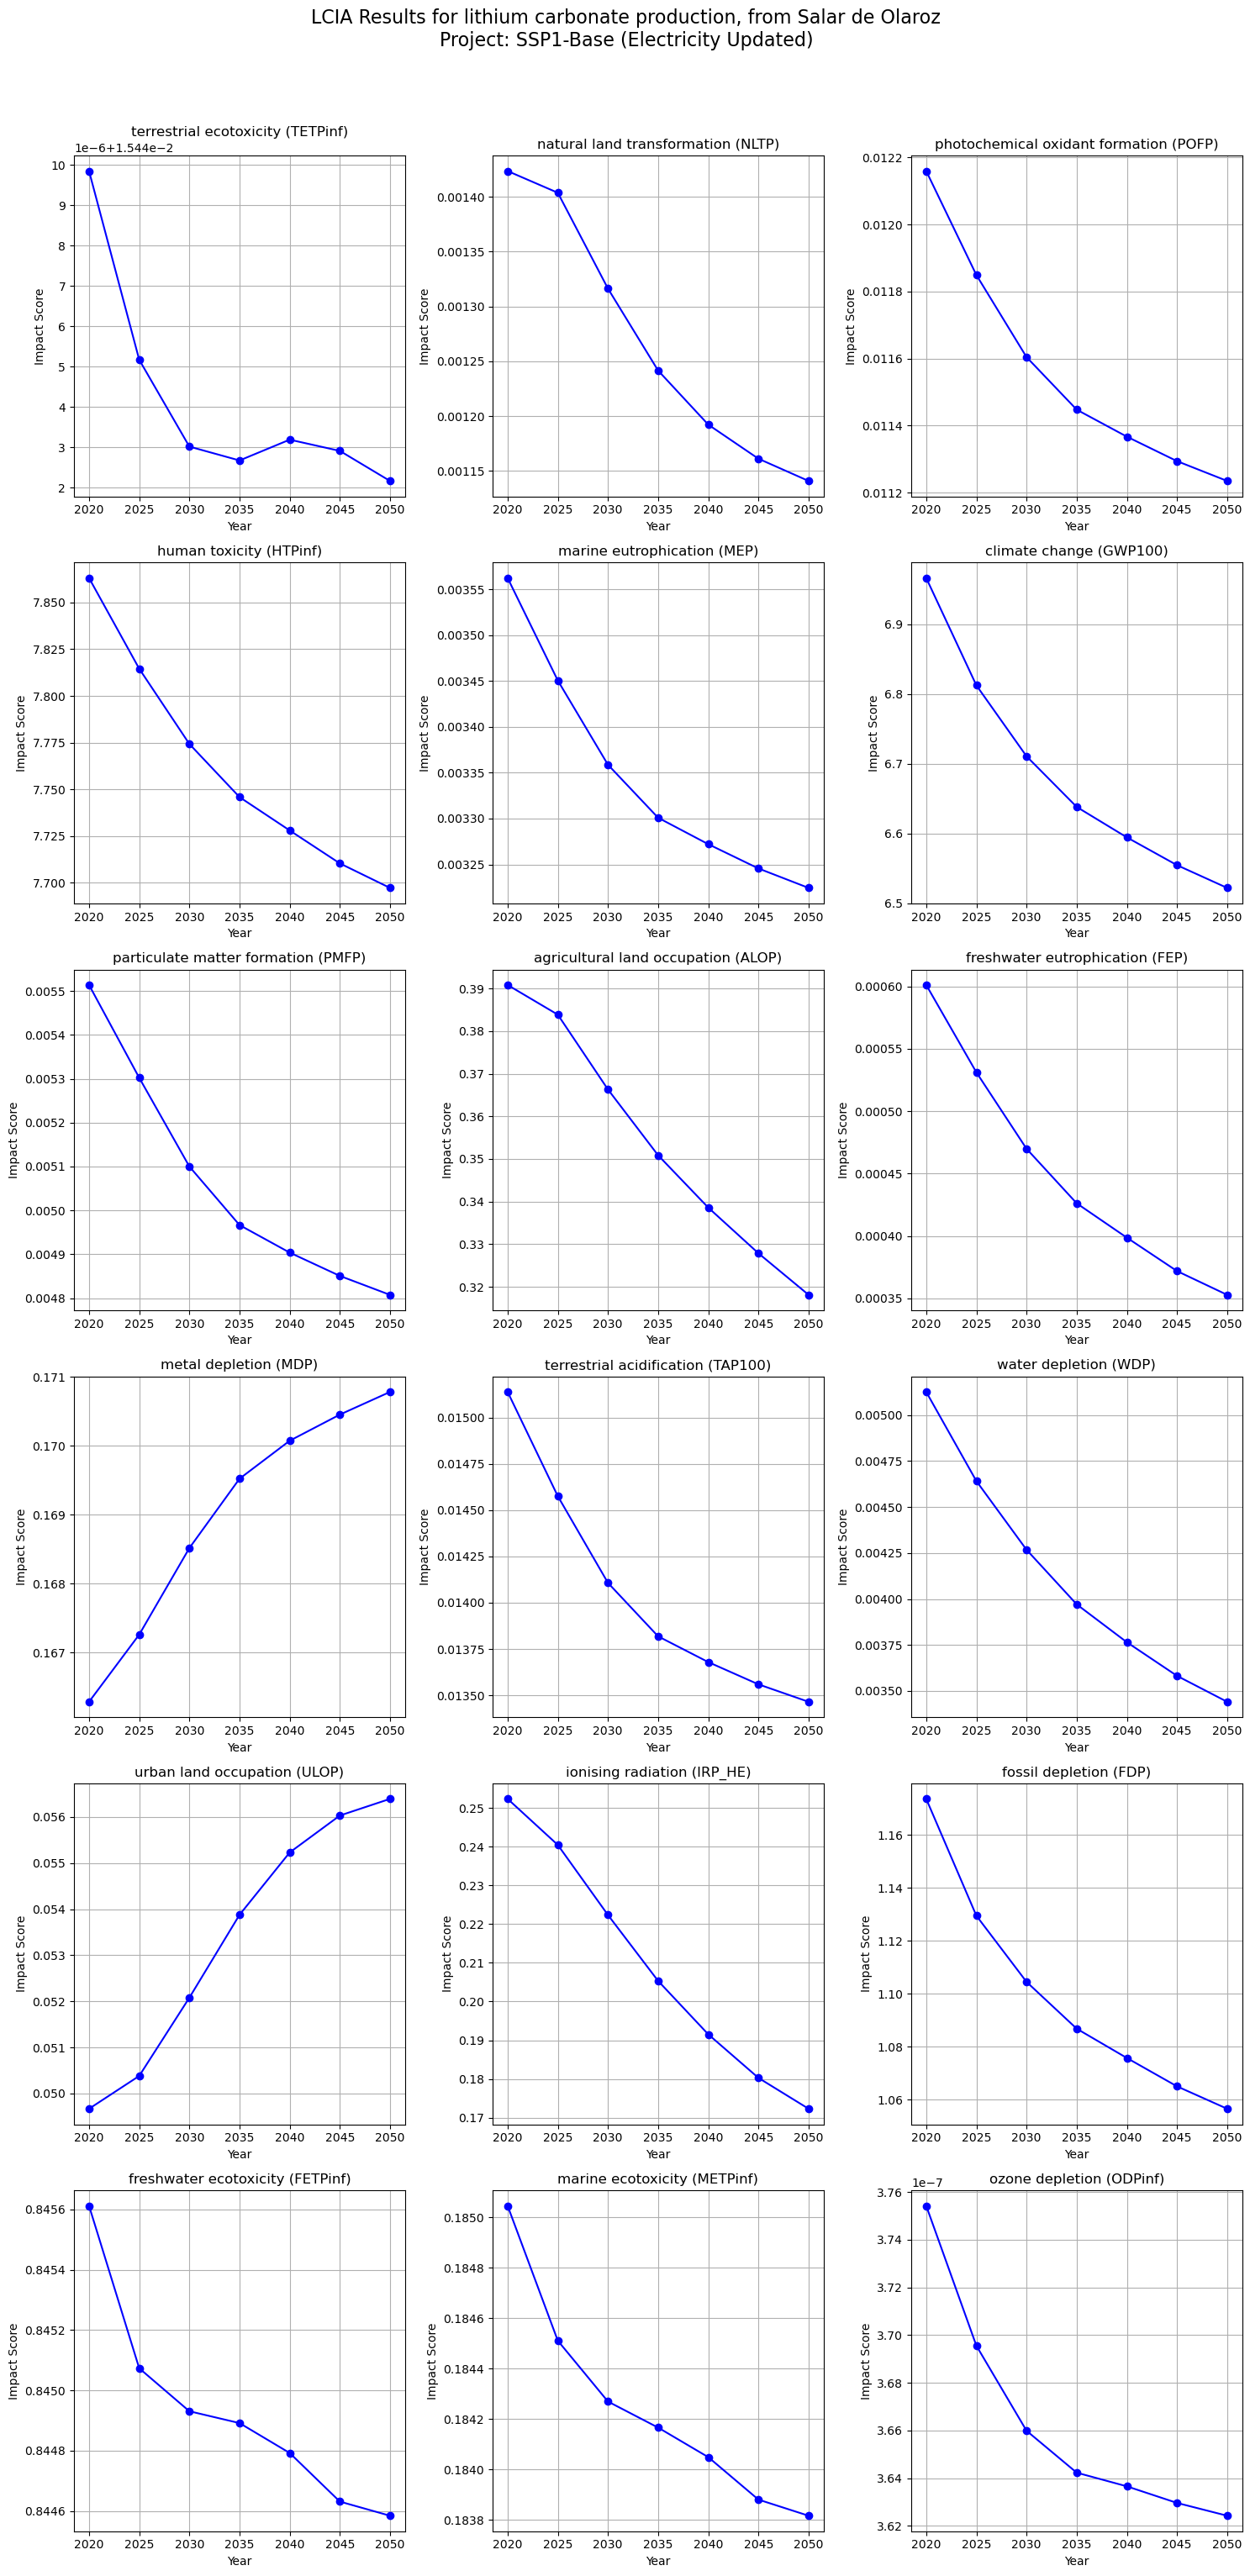

In [29]:
# Run the LCIA across all years
lcia_results_per_year = run_lcia_across_years(activity_name, recipe_midpoint_h, databases_remindSSP1_energy)
plot_combined_lcia_results_across_years(lcia_results_per_year, recipe_midpoint_h, activity_name, "SSP1-Base (Electricity Updated)")

### 1.1.3. lithium carbonate production, from Salar de Cauchari-Olaroz

In [30]:
# Search term from updated SSP1-Base2020 database.
# Updated from:
## Source: Jarod C. Kelly, Michael Wang, Qiang Dai, Olumide Winjobi, Energy, greenhouse gas, and water life cycle analysis of lithium carbonate and lithium hydroxide monohydrate from brine and ore resources and their use in lithium ion battery cathodes and lithium ion batteries, Resources, Conservation and Recycling, Volume 174, 2021, 105762, ISSN 0921-3449, https://doi.org/10.1016/j.resconrec.2021.105762.
activity_name = 'lithium carbonate production, from Salar de Cauchari-Olaroz'

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.0077214312312500035
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.0021099119868671053
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.014401325002724966
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 4.849889253808659
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.00428895216066504
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 7.4692677884807654
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.0070227476919264425
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.42229764475982406
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.001051222898392571
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 0.28832072548127385
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.02079636784811765
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.007974008999366643
('ReCiPe Midpoint (H)', 'urban land occ

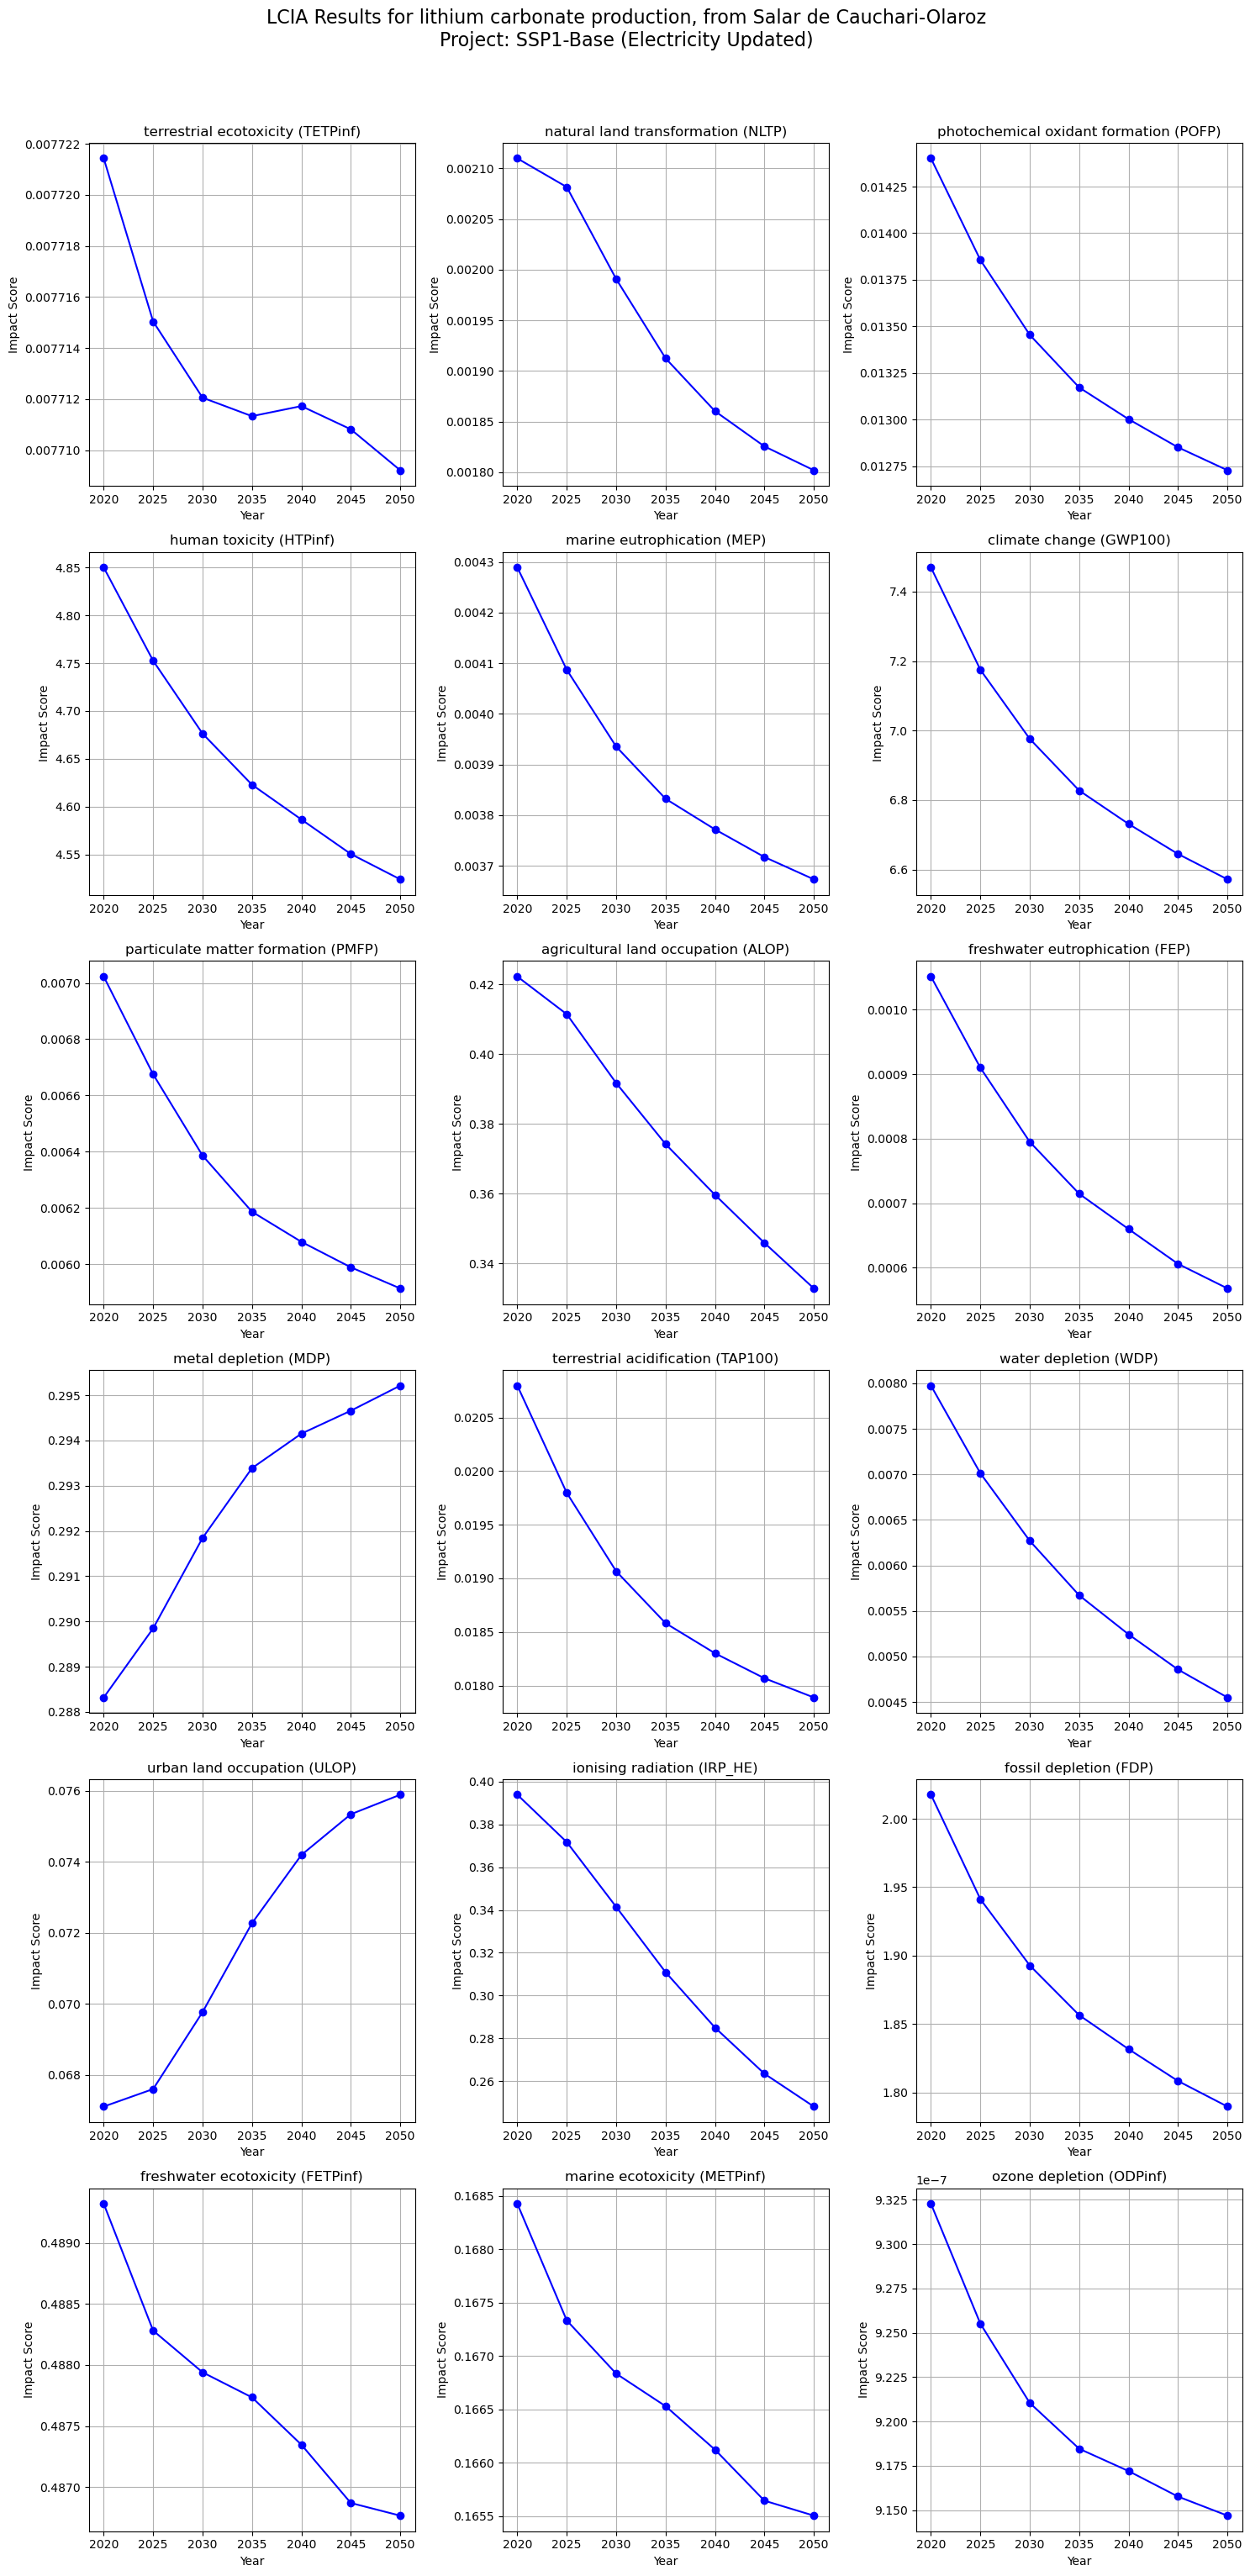

In [31]:
# Run the LCIA across all years
lcia_results_per_year = run_lcia_across_years(activity_name, recipe_midpoint_h, databases_remindSSP1_energy)
plot_combined_lcia_results_across_years(lcia_results_per_year, recipe_midpoint_h, activity_name, "SSP1-Base (Electricity Updated)")

### 1.1.4. lithium carbonate production, from Salar del Hombre Muerto

In [33]:
# Search term from updated SSP1-Base2020 database.
# Updated from:
## Source: Jarod C. Kelly, Michael Wang, Qiang Dai, Olumide Winjobi, Energy, greenhouse gas, and water life cycle analysis of lithium carbonate and lithium hydroxide monohydrate from brine and ore resources and their use in lithium ion battery cathodes and lithium ion batteries, Resources, Conservation and Recycling, Volume 174, 2021, 105762, ISSN 0921-3449, https://doi.org/10.1016/j.resconrec.2021.105762.
activity_name = 'lithium carbonate production, from Salar del Hombre Muerto'

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.0008885828923813529
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.0035692614166269883
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.017386602711662667
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 1.6932361594026566
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.004882377230366671
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 7.69142276375882
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.008262393819330447
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.42291065672641226
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.0010332011549291846
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 0.3027821922758736
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.024596654239186916
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.008136955172367455
('ReCiPe Midpoint (H)', 'urban land occ

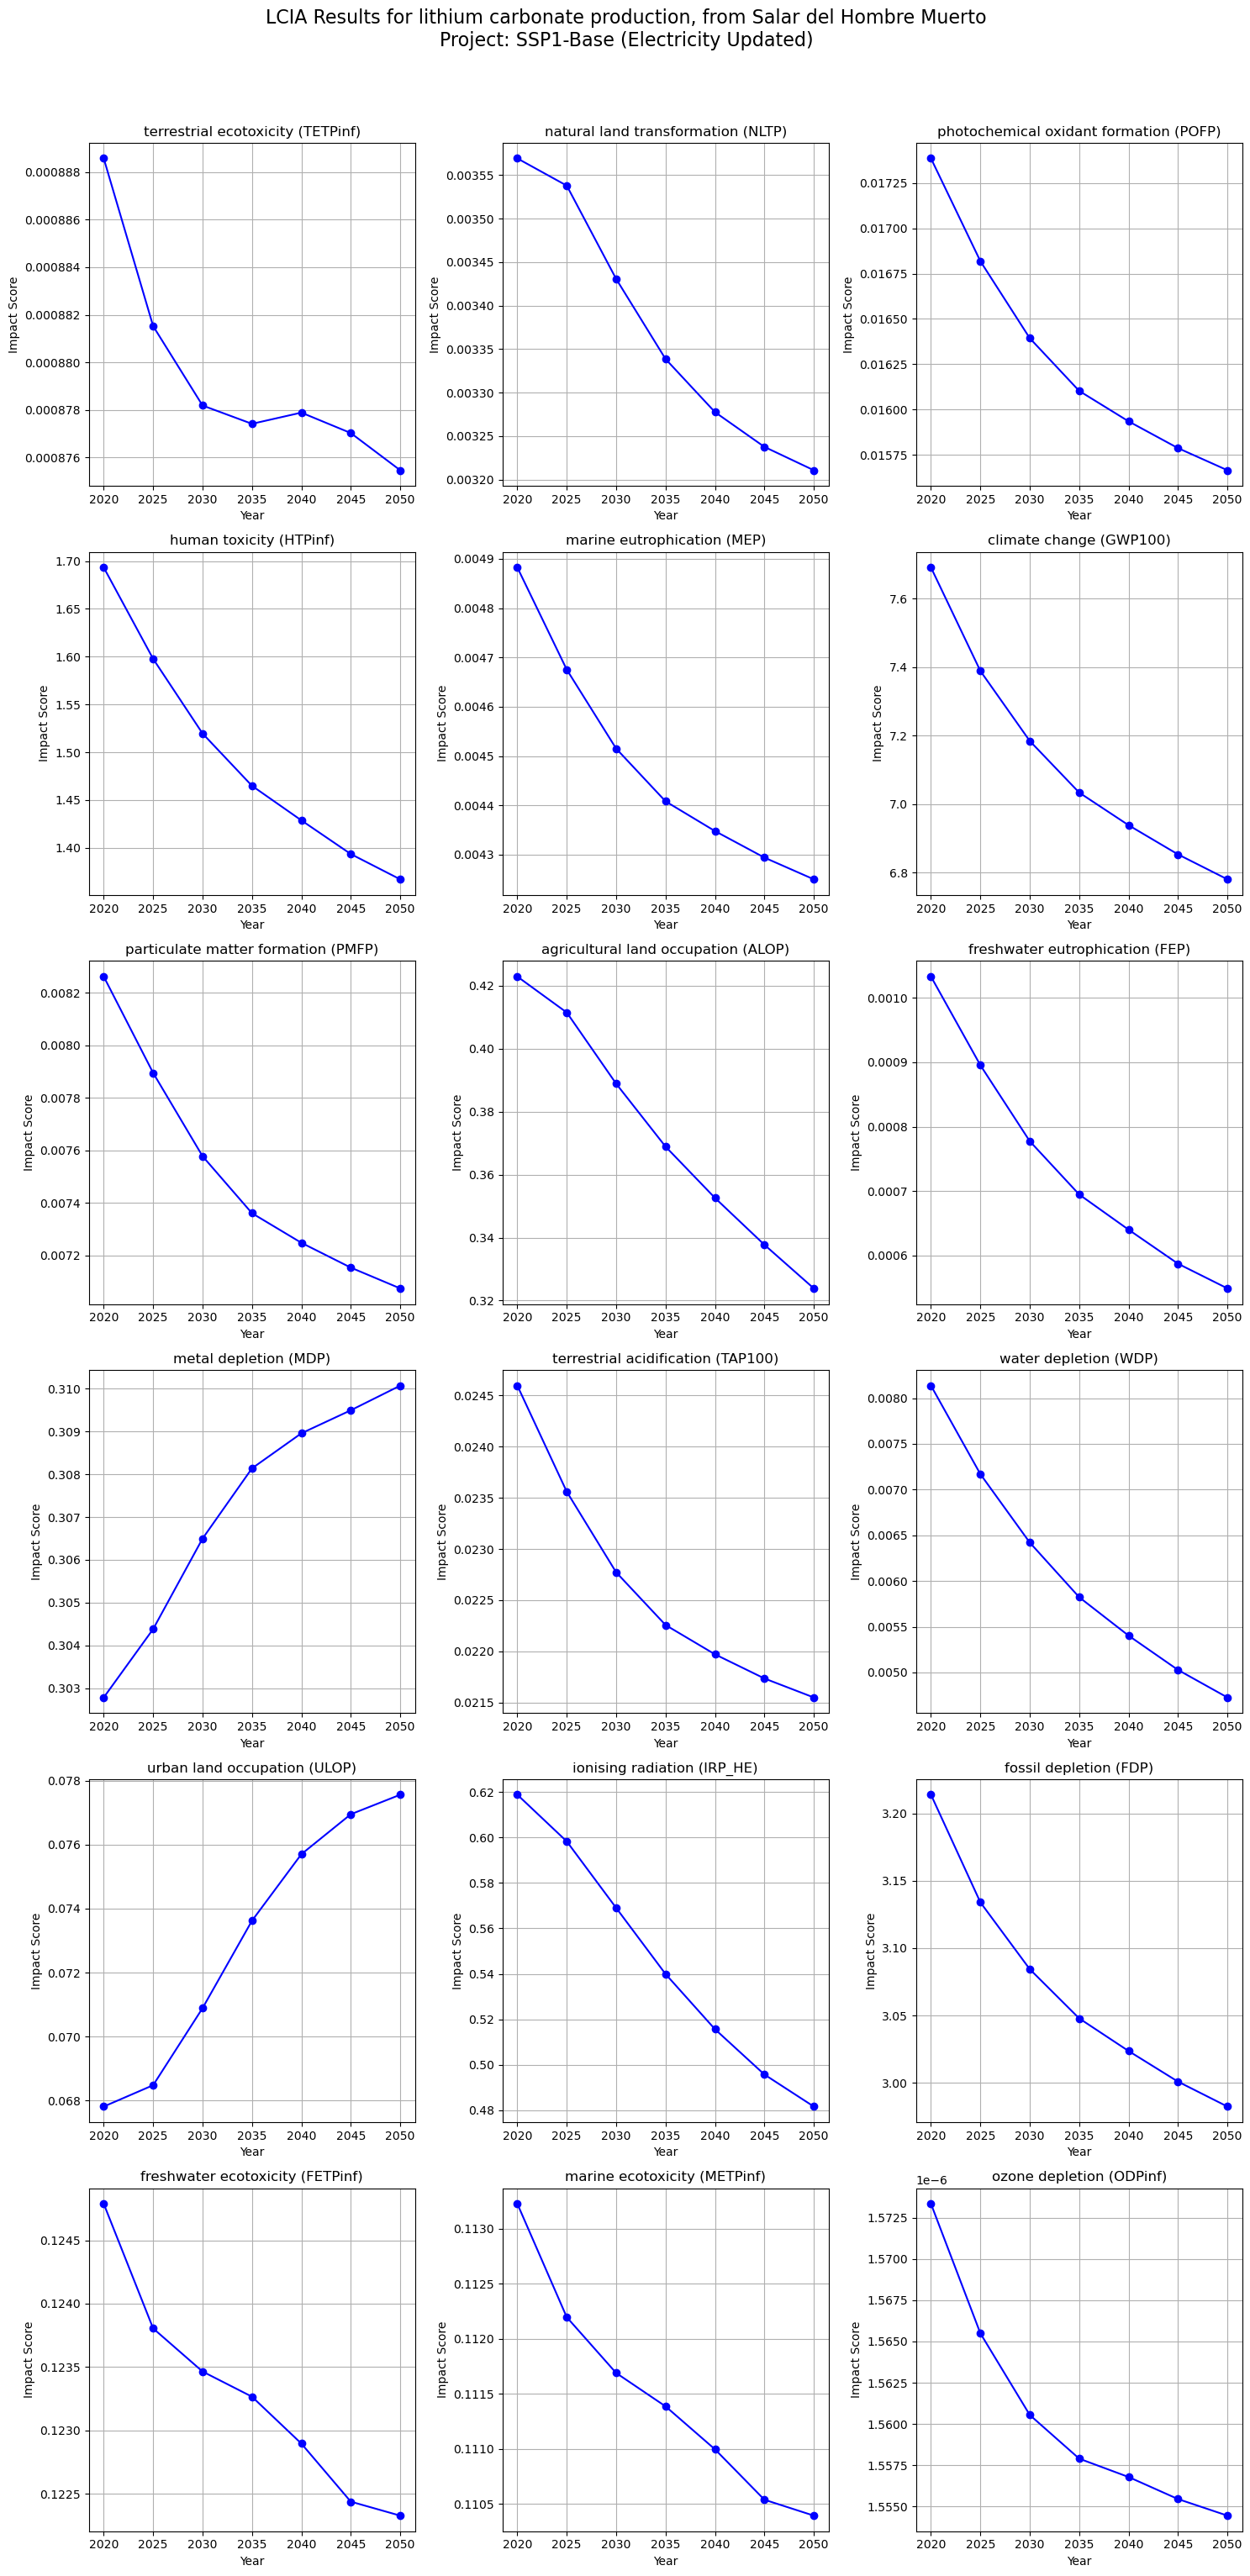

In [34]:
# Run the LCIA across all years
lcia_results_per_year = run_lcia_across_years(activity_name, recipe_midpoint_h, databases_remindSSP1_energy)
plot_combined_lcia_results_across_years(lcia_results_per_year, recipe_midpoint_h, activity_name, "SSP1-Base (Electricity Updated)")

### 1.1.5. lithium carbonate production, from Chaerhan salt lake

In [35]:
# Search term from updated SSP1-Base2020 database.
# Updated from:
## Source: Jarod C. Kelly, Michael Wang, Qiang Dai, Olumide Winjobi, Energy, greenhouse gas, and water life cycle analysis of lithium carbonate and lithium hydroxide monohydrate from brine and ore resources and their use in lithium ion battery cathodes and lithium ion batteries, Resources, Conservation and Recycling, Volume 174, 2021, 105762, ISSN 0921-3449, https://doi.org/10.1016/j.resconrec.2021.105762.
activity_name = 'lithium carbonate production, from Chaerhan salt lake'

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.17535254143617973
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.00892488808559975
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.07322485734020291
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 87.64569927440313
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.023351050000921775
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 48.035808859494885
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.032855991393968886
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 1.117439950483478
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.0068406773180329
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 0.6249940970271701
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.086836173169197
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.09073046588886816
('ReCiPe Midpoint (H)', 'urban land occupation', 'UL

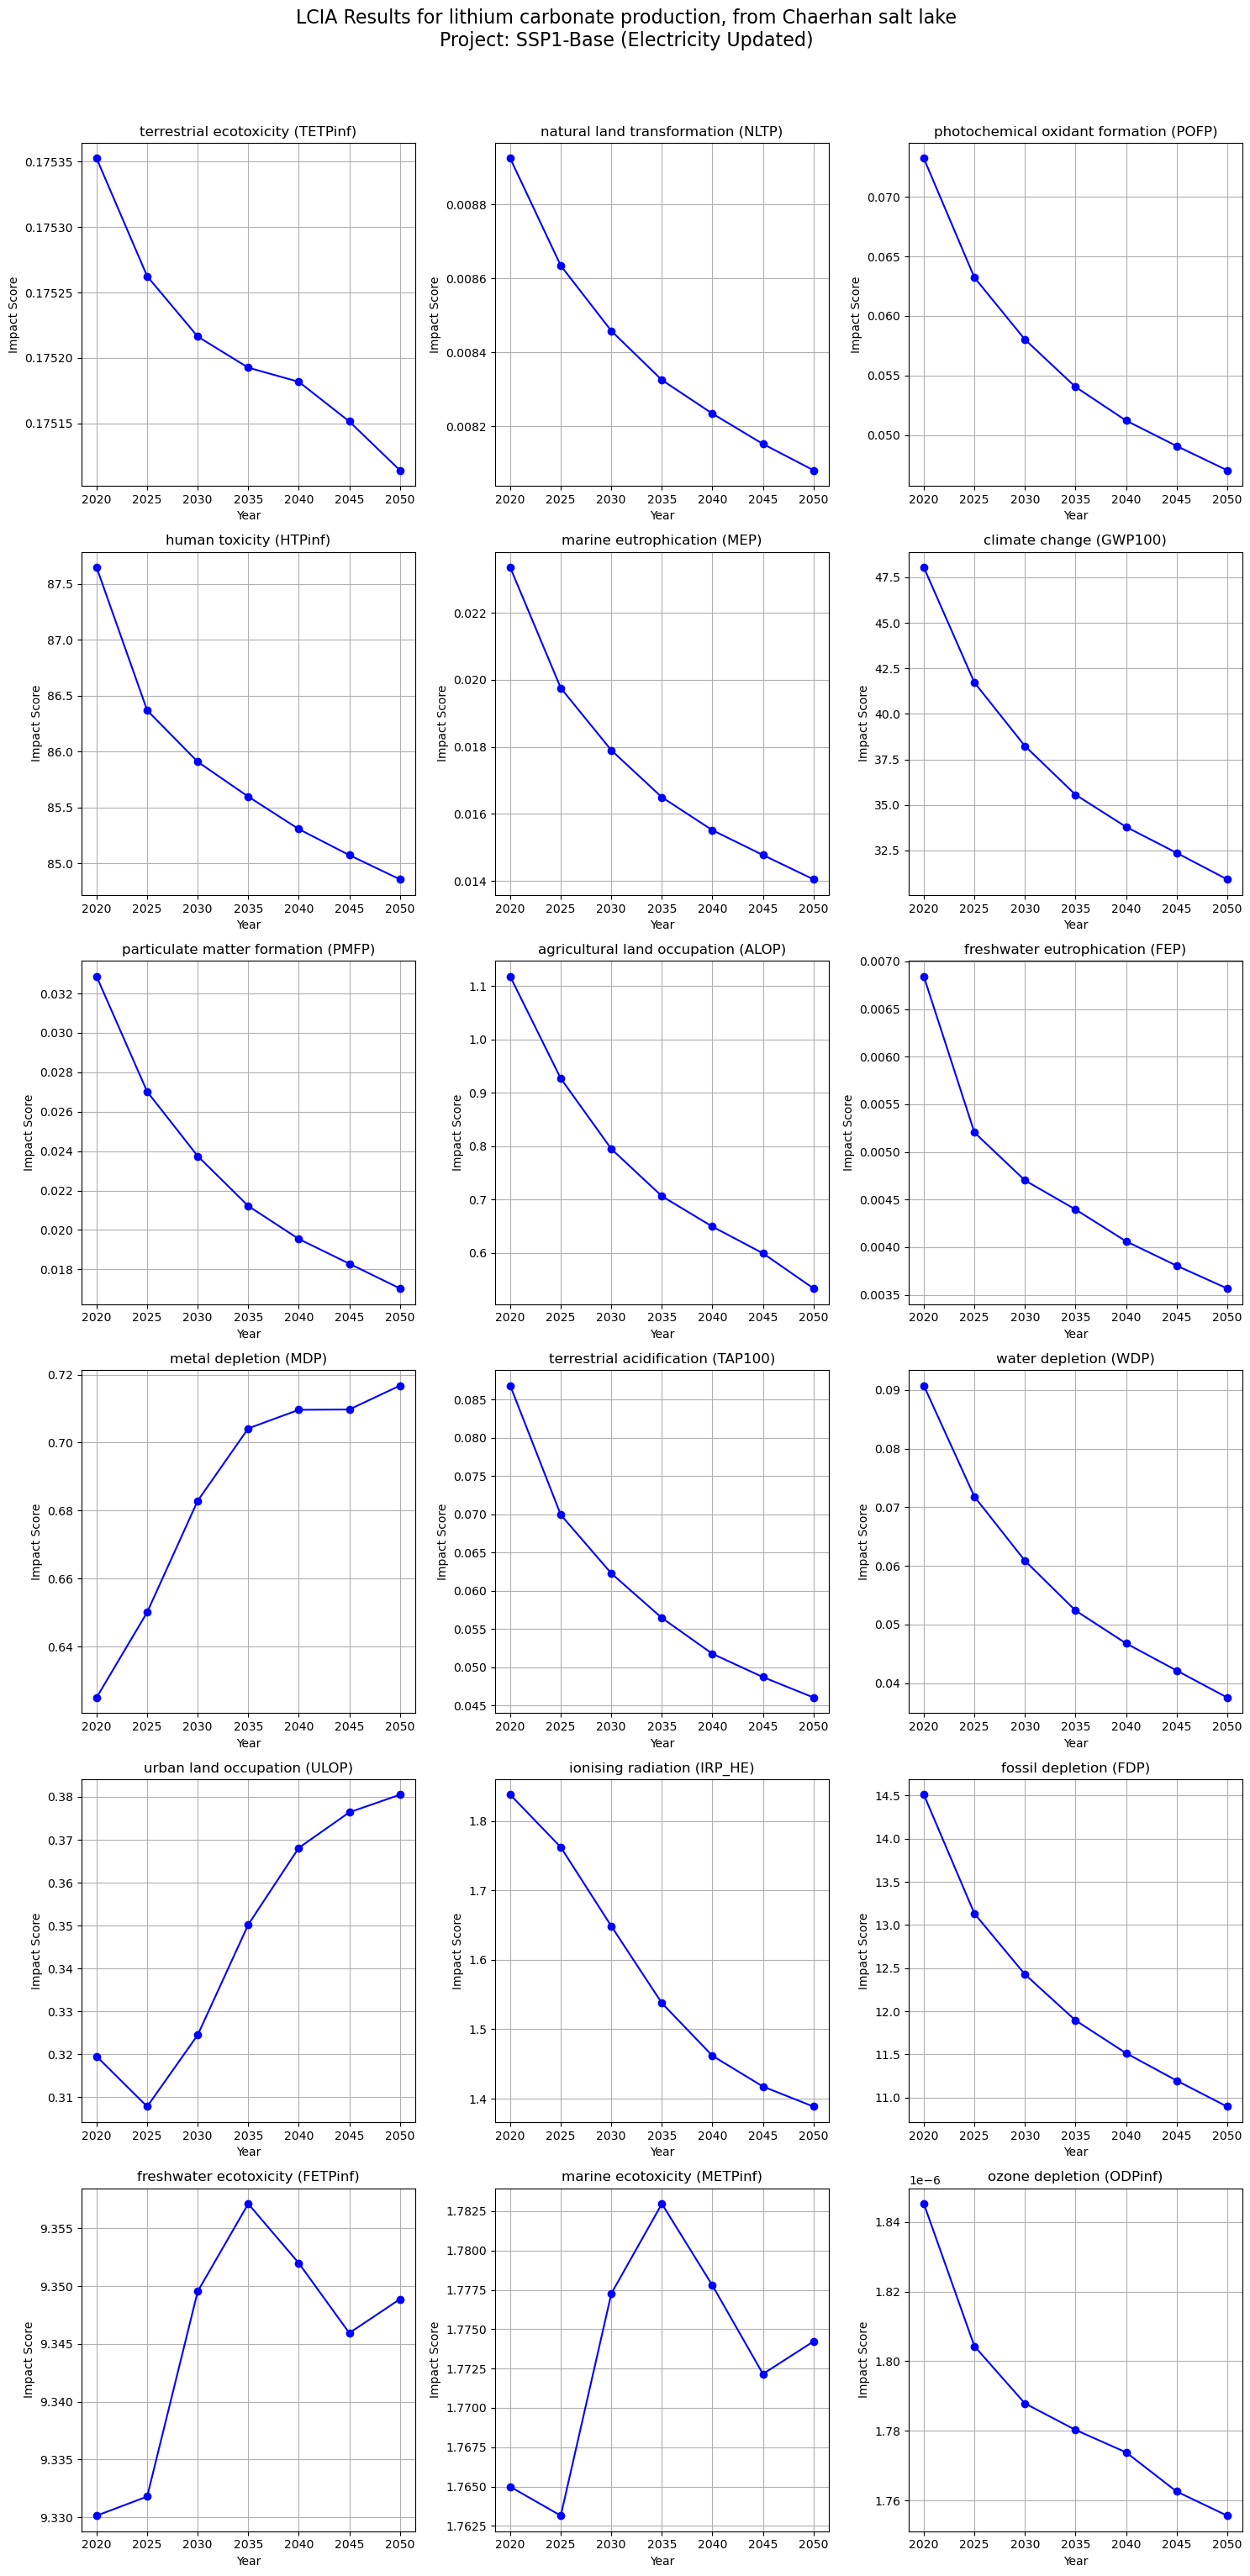

In [36]:
# Run the LCIA across all years
lcia_results_per_year = run_lcia_across_years(activity_name, recipe_midpoint_h, databases_remindSSP1_energy)
plot_combined_lcia_results_across_years(lcia_results_per_year, recipe_midpoint_h, activity_name, "SSP1-Base (Electricity Updated)")

## 3.2. All compared

In [37]:
# Run LCIA for all activities across all years
lcia_results_all_activities = run_lcia_for_multiple_activities(activities_li, recipe_midpoint_h, databases_remindSSP1_energy)

Processing activity: lithium carbonate production, from Salar de Atacama
('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.0003329566962788494
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.0013366815263864352
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.00861088992773888
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 1.0070318590116354
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.0026960593978378224
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 3.185952325892311
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.004558360033071338
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.25974508904597476
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.0006471257903494071
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 0.21038896775542384
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.014924496742181052
('ReCiPe Midpoint (H)', 'water deple

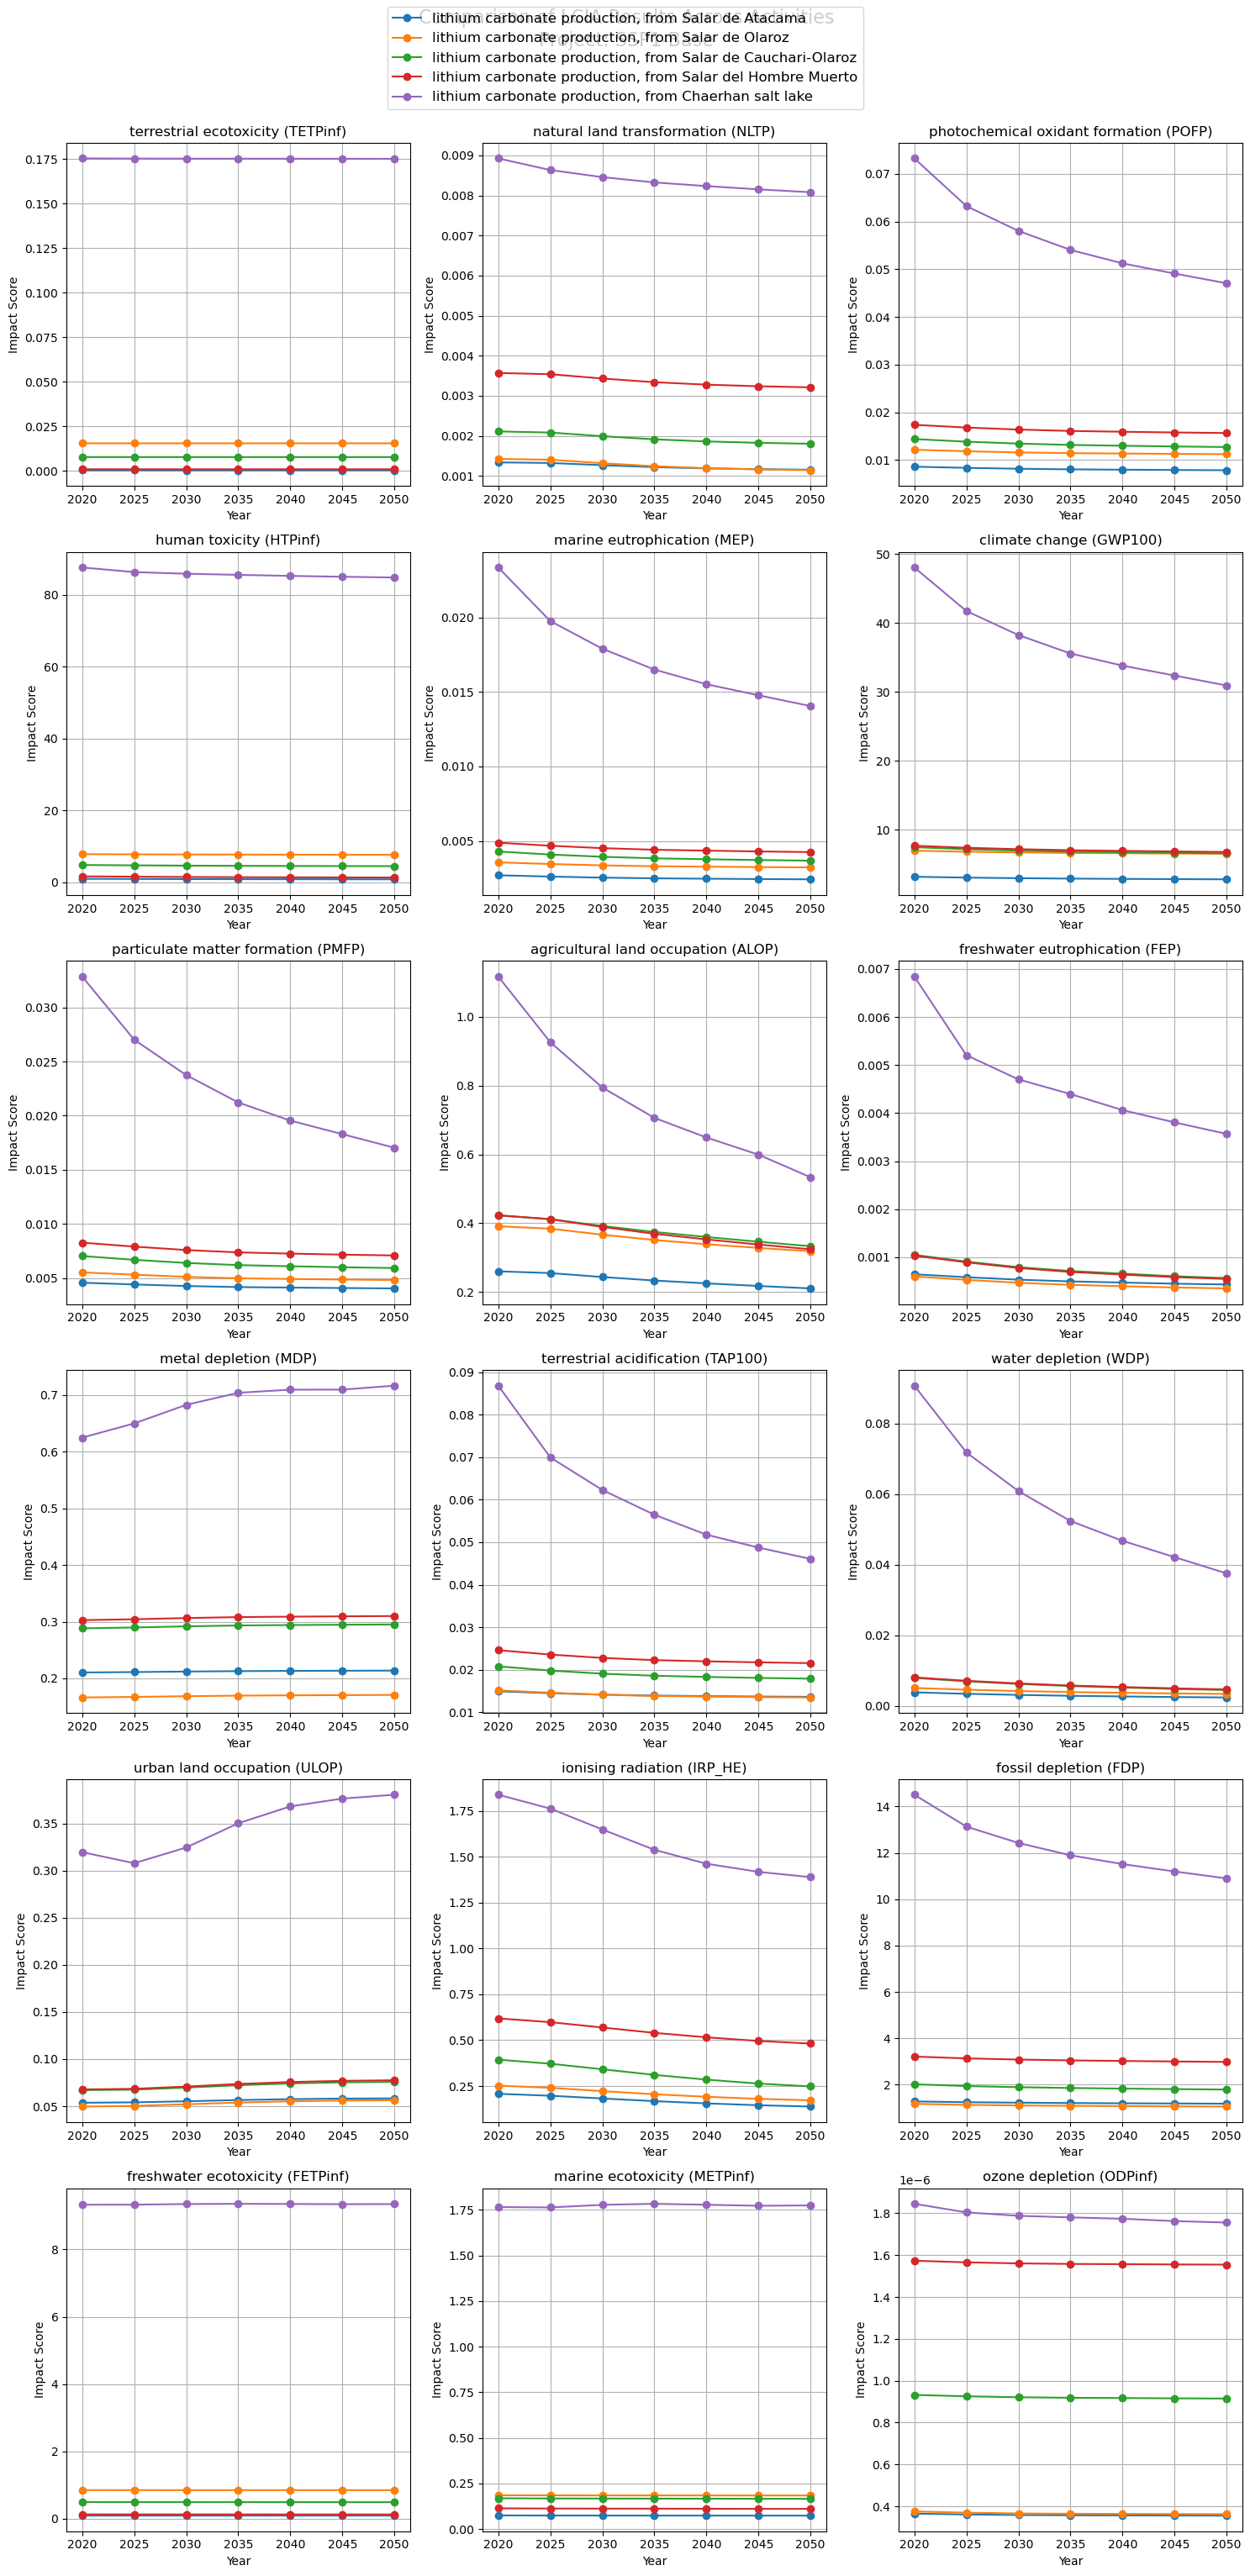

In [38]:
# Plot comparison of results across activities
plot_comparison_across_activities(lcia_results_all_activities, recipe_midpoint_h, activities_li)

# 4. Nickel

## 4.1. nickel, class 1

In [52]:
# Search term from updated SSP1-Base2020 database.
# Updated from:
## Source: Jarod C. Kelly, Michael Wang, Qiang Dai, Olumide Winjobi, Energy, greenhouse gas, and water life cycle analysis of lithium carbonate and lithium hydroxide monohydrate from brine and ore resources and their use in lithium ion battery cathodes and lithium ion batteries, Resources, Conservation and Recycling, Volume 174, 2021, 105762, ISSN 0921-3449, https://doi.org/10.1016/j.resconrec.2021.105762.
activity_name = 'nickel, class 1'

In [53]:
# Run the LCIA across all years
lcia_results_per_year = run_lcia_across_years(activity_name, recipe_midpoint_h, databases_remindSSP1_energy)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.018152256406060954
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.0069903517966915
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.22743081810415638
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 31.214021054275957
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.034806413397955704
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 16.294615572248972
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.3260878177858108
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.6173962809409747
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.014371313793115646
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 60.53910366768722
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 1.5190253776179732
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.23383486459954198
('ReCiPe Midpoint (H)', 'urban land occupation', '

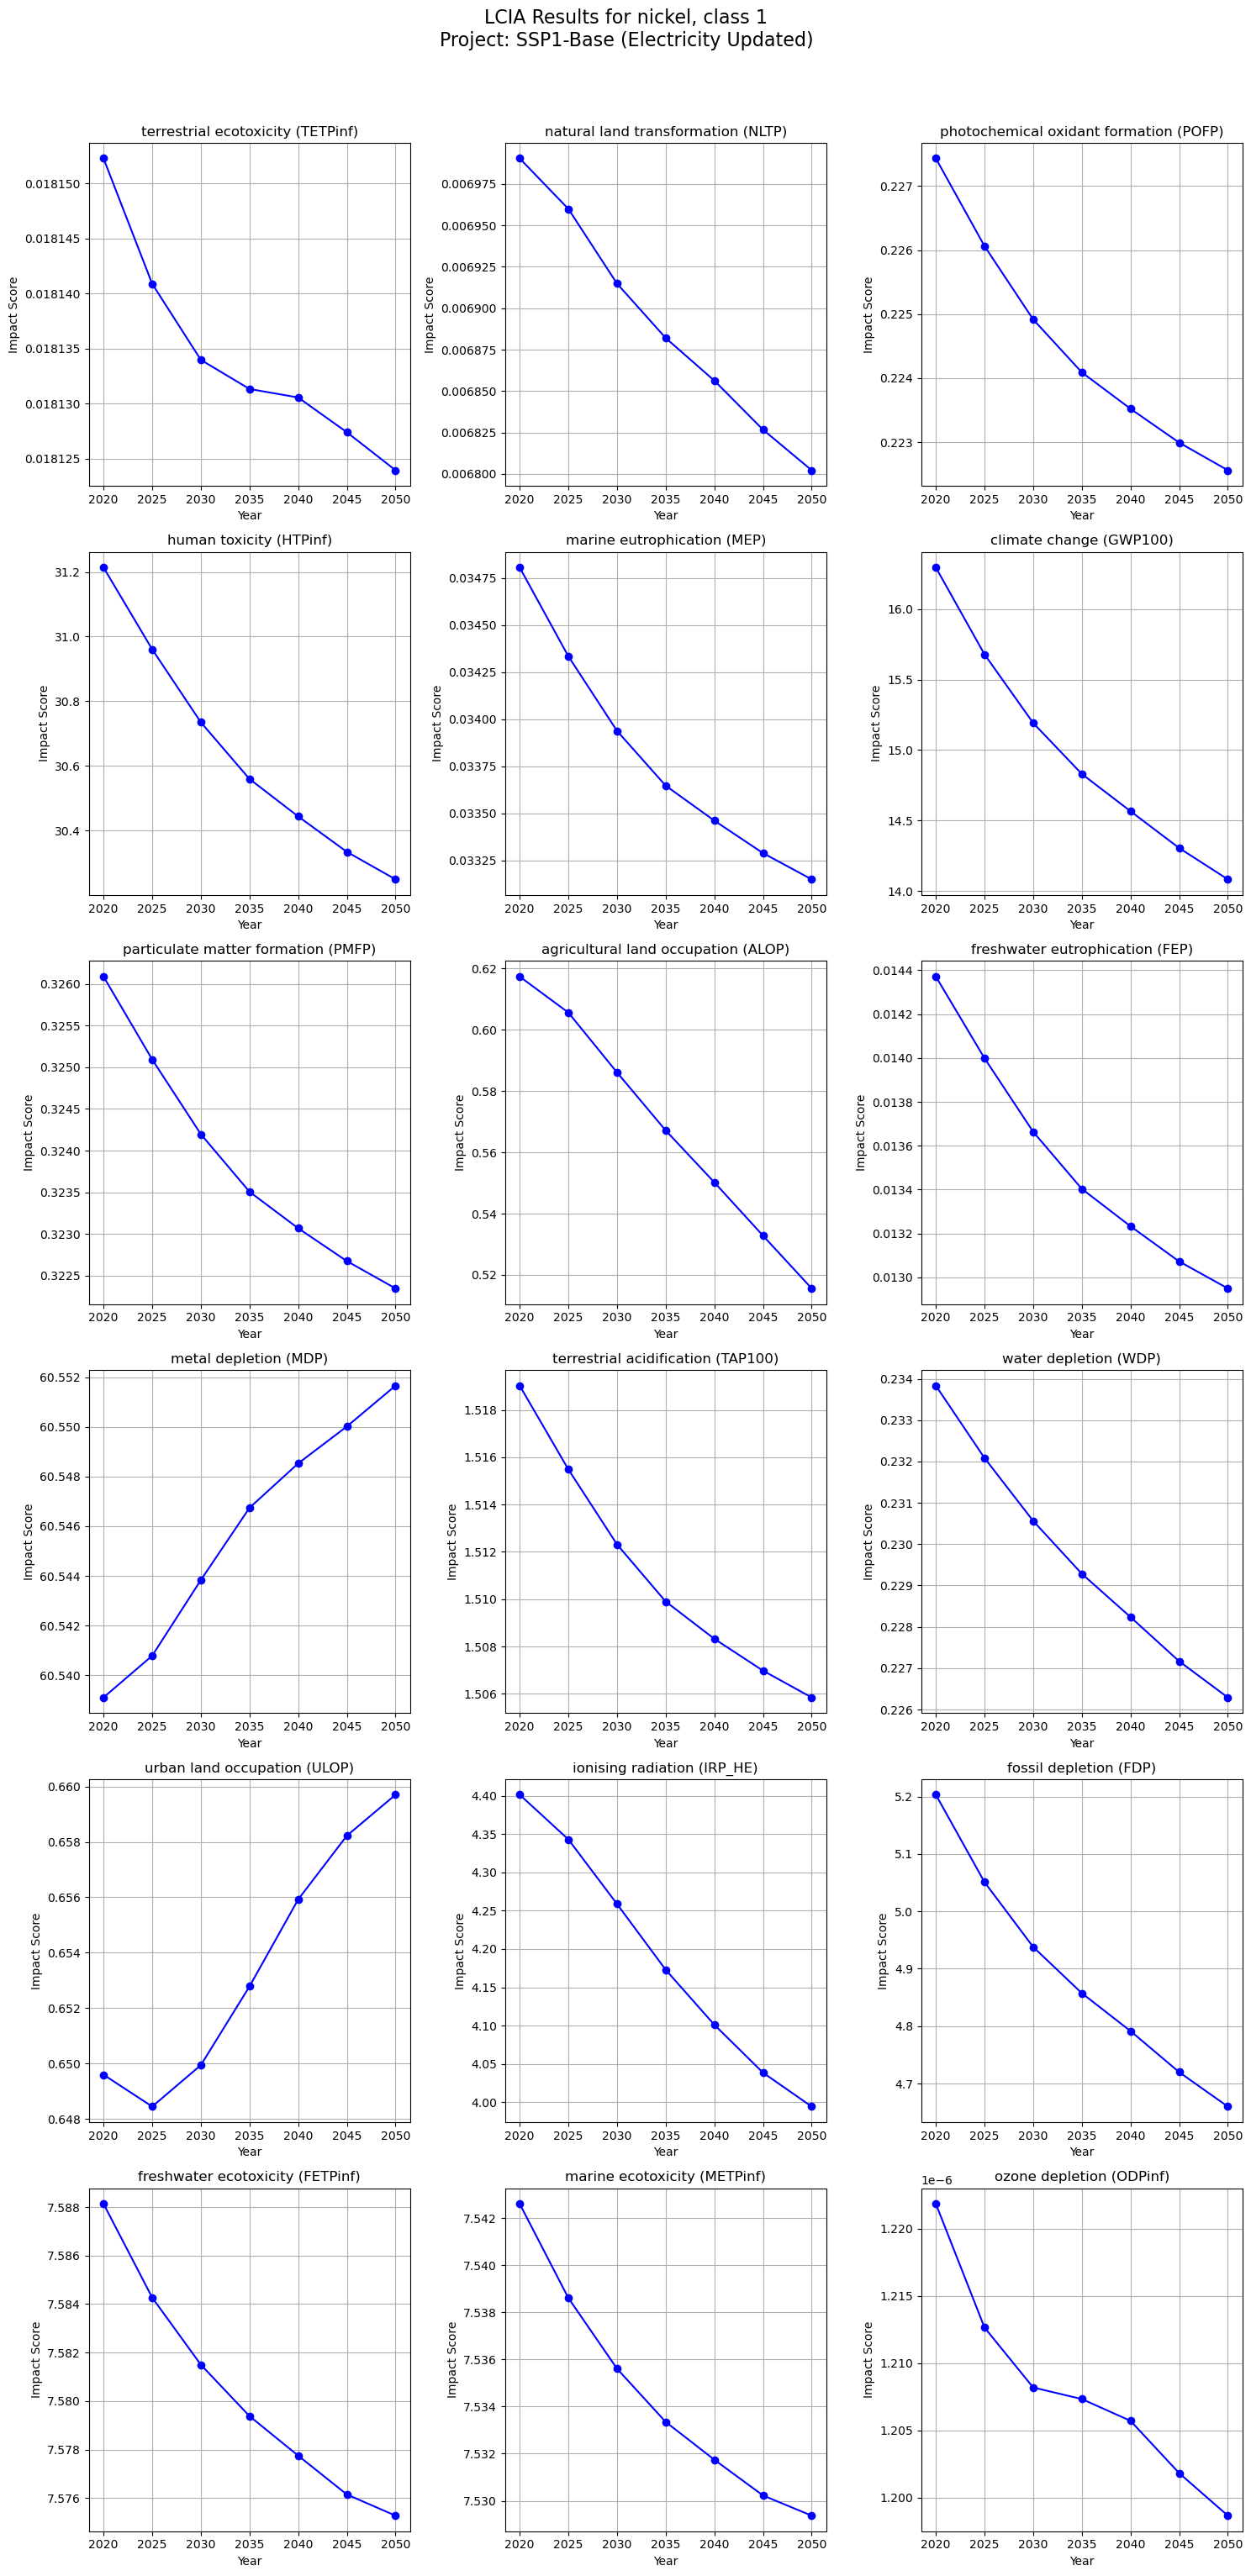

In [54]:
plot_combined_lcia_results_across_years(lcia_results_per_year, recipe_midpoint_h, activity_name, "SSP1-Base (Electricity Updated)")

In [32]:
# Search term from updated SSP1-Base2020 database.
# Updated from:
# search_term = "market for nickel, class 1"

In [44]:
# exchanges = search_and_get_exchanges(db, search_term)
# exchanges

[Exchange: 0.3614 ton kilometer 'market group for transport, freight, lorry, unspecified' (ton kilometer, GLO, None) to 'market for nickel, class 1' (kilogram, GLO, None)>,
 Exchange: 1.0 kilogram 'market for nickel, class 1' (kilogram, GLO, None) to 'market for nickel, class 1' (kilogram, GLO, None)>,
 Exchange: 0.3633 ton kilometer 'market for transport, freight, sea, container ship' (ton kilometer, GLO, None) to 'market for nickel, class 1' (kilogram, GLO, None)>,
 Exchange: 0.3448 ton kilometer 'market group for transport, freight train' (ton kilometer, GLO, None) to 'market for nickel, class 1' (kilogram, GLO, None)>,
 Exchange: 0.0363 ton kilometer 'market group for transport, freight, inland waterways, barge' (ton kilometer, GLO, None) to 'market for nickel, class 1' (kilogram, GLO, None)>,
 Exchange: 5.36263530789971e-06 kilogram 'treatment of metal part of electronics scrap, in copper, anode, by electrolytic refining' (kilogram, SE, None) to 'market for nickel, class 1' (kilog

In [45]:
# elementary_flows = filter_and_display_elementary_flows(exchanges)

In [46]:
'''
Let's explore the following exchanges:
Exchange: 0.161162933095465 kilogram 'platinum group metal mine operation, ore with high palladium content' (kilogram, RU, None) to 'market for nickel, class 1' (kilogram, GLO, None)>,
Exchange: 0.0309617633971047 kilogram 'platinum group metal, extraction and refinery operations' (kilogram, ZA, None) to 'market for nickel, class 1' (kilogram, GLO, None)>,
Exchange: 0.139645918974656 kilogram 'processing of nickel-rich materials' (kilogram, GLO, None) to 'market for nickel, class 1' (kilogram, GLO, None)>,
Exchange: 0.161885636831319 kilogram 'smelting and refining of nickel concentrate, 16% Ni' (kilogram, GLO, None) to 'market for nickel, class 1' (kilogram, GLO, None)>,
Exchange: 0.167667266718152 kilogram 'smelting and refining of nickel concentrate, 7% Ni' (kilogram, CN, None) to 'market for nickel, class 1' (kilogram, GLO, None)>,
Exchange: 0.00202310190815179 kilogram 'treatment of metal part of electronics scrap, in copper, anode, by electrolytic refining' (kilogram, RoW, None) to 'market for nickel, class 1' (kilogram, GLO, None)>,
Exchange: 0.336648016439843 kilogram 'cobalt production' (kilogram, GLO, None) to 'market for nickel, class 1' (kilogram, GLO, None)>]
'''


"\nLet's explore the following exchanges:\nExchange: 0.161162933095465 kilogram 'platinum group metal mine operation, ore with high palladium content' (kilogram, RU, None) to 'market for nickel, class 1' (kilogram, GLO, None)>,\nExchange: 0.0309617633971047 kilogram 'platinum group metal, extraction and refinery operations' (kilogram, ZA, None) to 'market for nickel, class 1' (kilogram, GLO, None)>,\nExchange: 0.139645918974656 kilogram 'processing of nickel-rich materials' (kilogram, GLO, None) to 'market for nickel, class 1' (kilogram, GLO, None)>,\nExchange: 0.161885636831319 kilogram 'smelting and refining of nickel concentrate, 16% Ni' (kilogram, GLO, None) to 'market for nickel, class 1' (kilogram, GLO, None)>,\nExchange: 0.167667266718152 kilogram 'smelting and refining of nickel concentrate, 7% Ni' (kilogram, CN, None) to 'market for nickel, class 1' (kilogram, GLO, None)>,\nExchange: 0.00202310190815179 kilogram 'treatment of metal part of electronics scrap, in copper, anode, 

### 4.1.1.

## 4.2. All compared across years

In [39]:
# Run LCIA for all activities across all years
lcia_results_all_activities = run_lcia_for_multiple_activities(activities_ni, recipe_midpoint_h, databases_remindSSP1_energy)

Processing activity: treatment of metal part of electronics scrap, in copper, anode, by electrolytic refining
('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.004394578137143717
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.005974447663460056
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.14109890453979992
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 851.0813117059962
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.04118356520529403
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 76.09183707343394
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.06442111454849789
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.8643388283485526
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.009040350269611459
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 1.0937775727650312
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.16881324417296625
('ReCiPe 

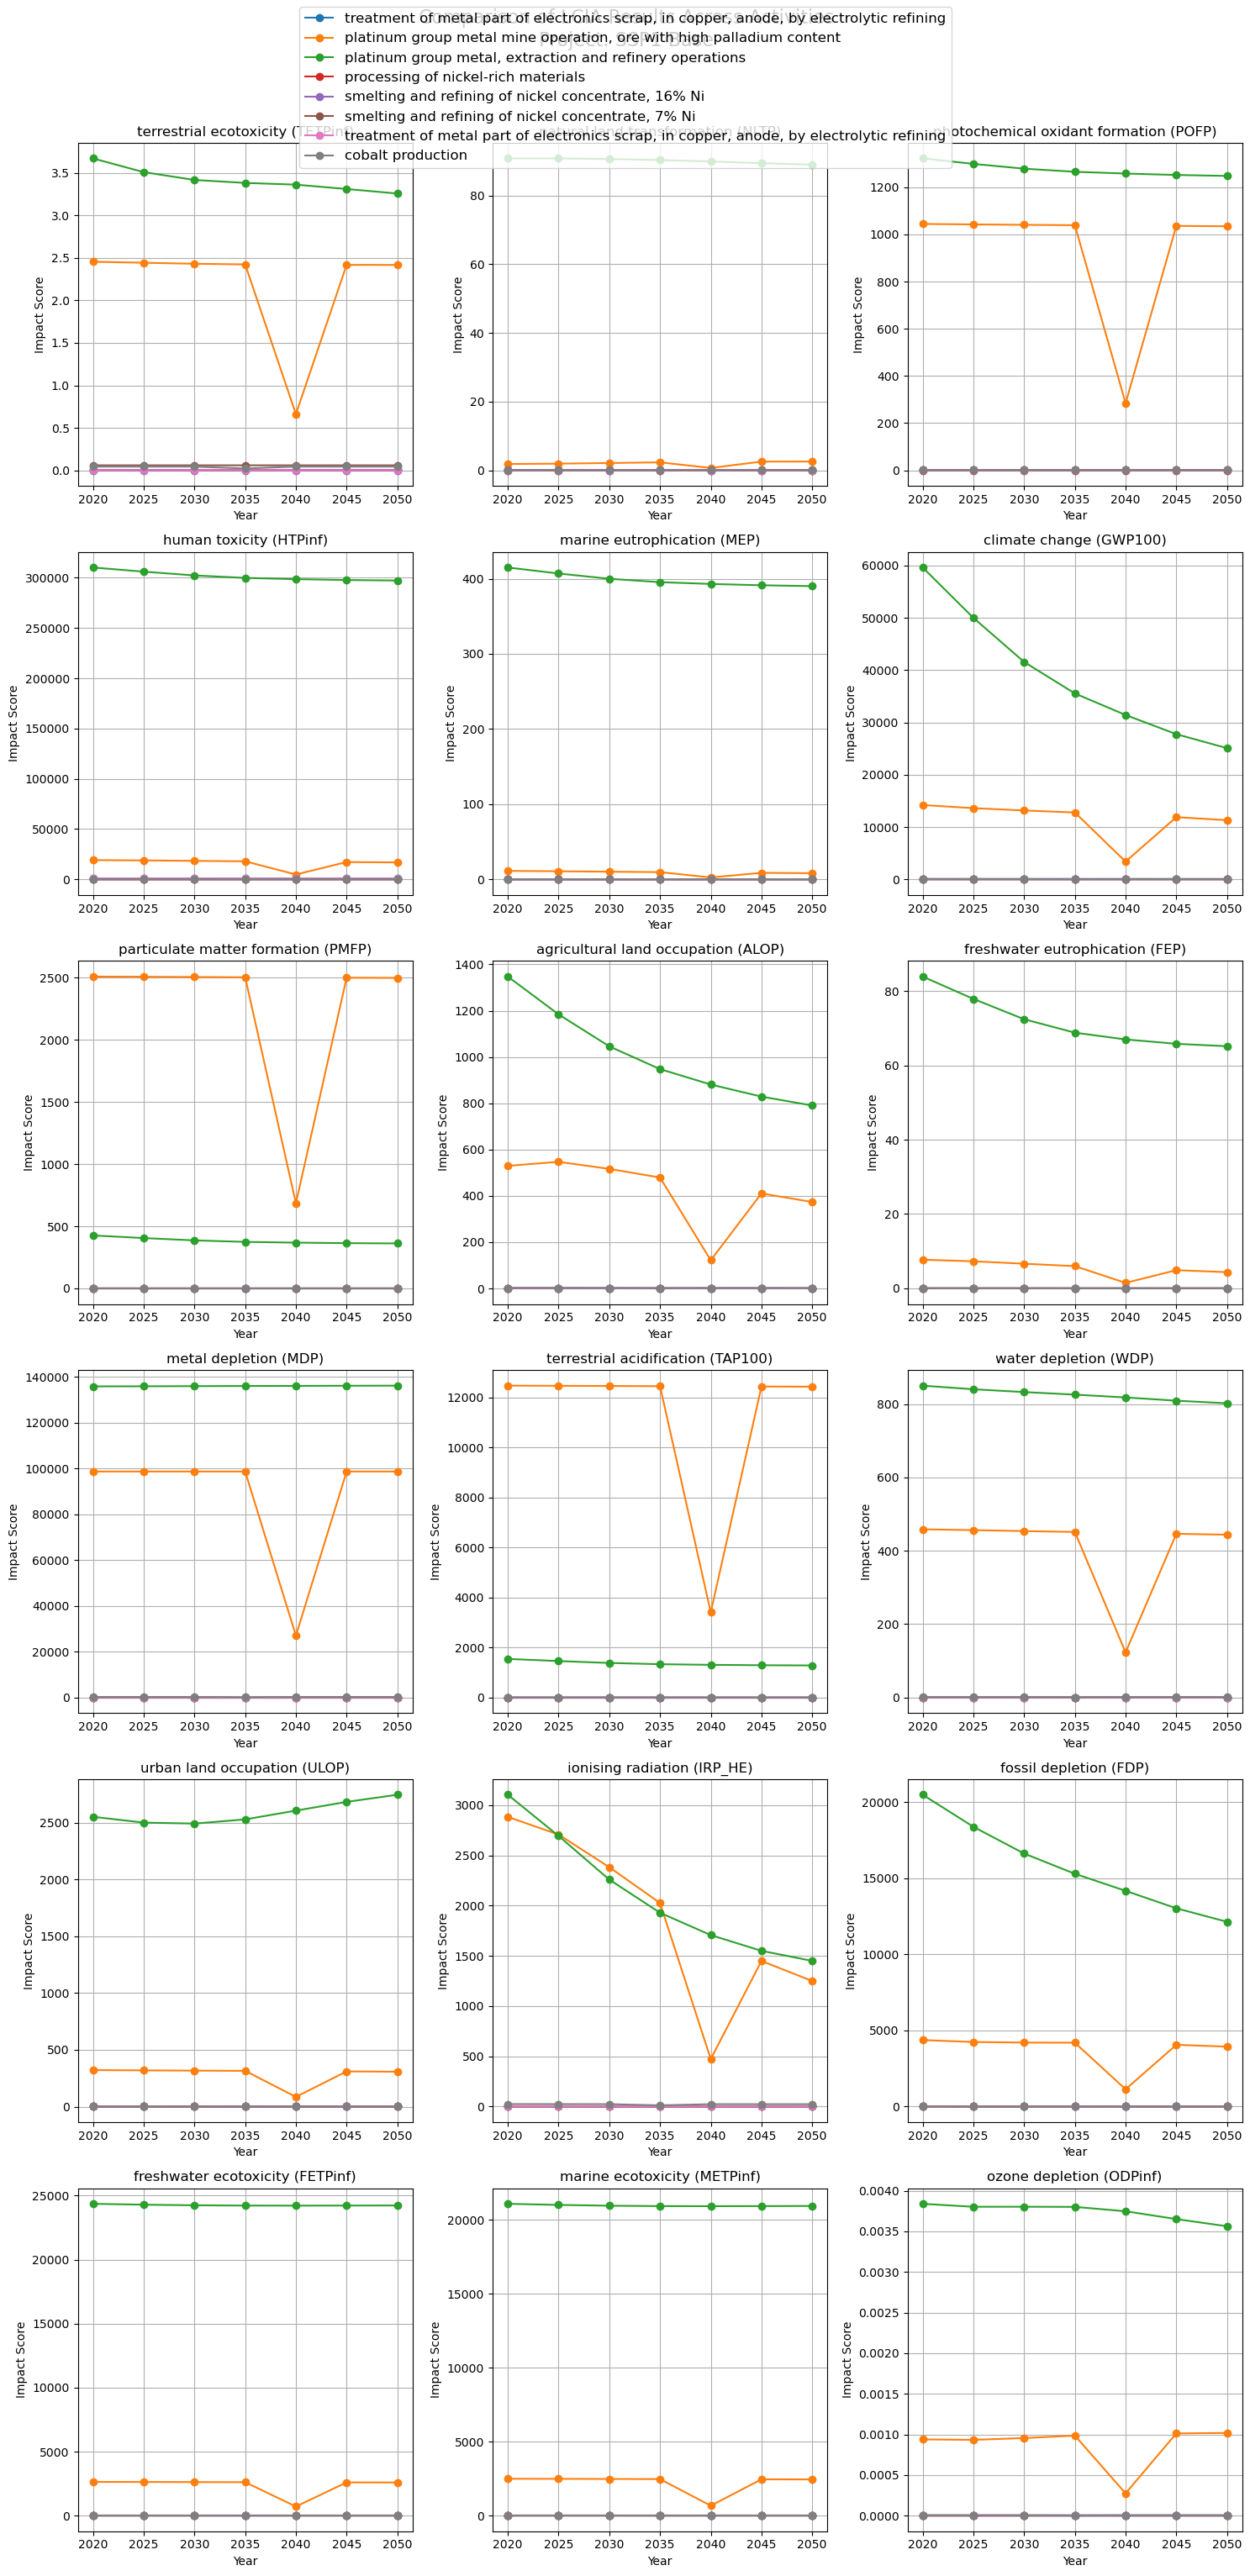

In [40]:
# Plot comparison of results across activities
plot_comparison_across_activities(lcia_results_all_activities, recipe_midpoint_h, activities_ni)

# 5. Manganese concentrate

In [51]:
# Search term from updated SSP1-Base2020 database.
# Updated from:
## Source: Jarod C. Kelly, Michael Wang, Qiang Dai, Olumide Winjobi, Energy, greenhouse gas, and water life cycle analysis of lithium carbonate and lithium hydroxide monohydrate from brine and ore resources and their use in lithium ion battery cathodes and lithium ion batteries, Resources, Conservation and Recycling, Volume 174, 2021, 105762, ISSN 0921-3449, https://doi.org/10.1016/j.resconrec.2021.105762.
# search_term = "market for manganese sulfate"


'''
When looking at NMC-811 hydroxide, we can see "manganese sulfate".
By exploring manganese sulfate, we can see:
-manganese dioxide production
-manganese sulfate production
both generating manganese sulfate

'''

In [52]:
# exchanges = search_and_get_exchanges(db, search_term)
# exchanges

[Exchange: 1.0 kilogram 'market for manganese concentrate' (kilogram, GLO, None) to 'market for manganese concentrate' (kilogram, GLO, None)>,
 Exchange: 0.3861 ton kilometer 'market group for transport, freight train' (ton kilometer, GLO, None) to 'market for manganese concentrate' (kilogram, GLO, None)>,
 Exchange: 0.3272 ton kilometer 'market group for transport, freight, inland waterways, barge' (ton kilometer, GLO, None) to 'market for manganese concentrate' (kilogram, GLO, None)>,
 Exchange: 1.699 ton kilometer 'market for transport, freight, sea, bulk carrier for dry goods' (ton kilometer, GLO, None) to 'market for manganese concentrate' (kilogram, GLO, None)>,
 Exchange: 0.1739 ton kilometer 'market group for transport, freight, lorry, unspecified' (ton kilometer, GLO, None) to 'market for manganese concentrate' (kilogram, GLO, None)>,
 Exchange: 1.0 kilogram 'manganese concentrate production' (kilogram, GLO, None) to 'market for manganese concentrate' (kilogram, GLO, None)>]

## 5.1. Manganese Sulfate

In [53]:
# Search term from updated SSP1-Base2020 database.
# Updated from:
activity_name = "market for manganese sulfate"

In [54]:
# Run the LCIA across all years
lcia_results_per_year = run_lcia_across_years(activity_name, recipe_midpoint_h, databases_remindSSP1_energy)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 2.3388892072866902e-06
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 7.76308634462059e-05
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.00031785852497290805
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 0.013298581553987533
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.00010645450837076915
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 0.01717223886216058
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.00011217599843825214
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.0018320501812615637
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 6.360163243900072e-06
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 46.97260980539226
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.00027622386360322303
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.0014422056164561184
('ReCiPe Midpoint (H)', 

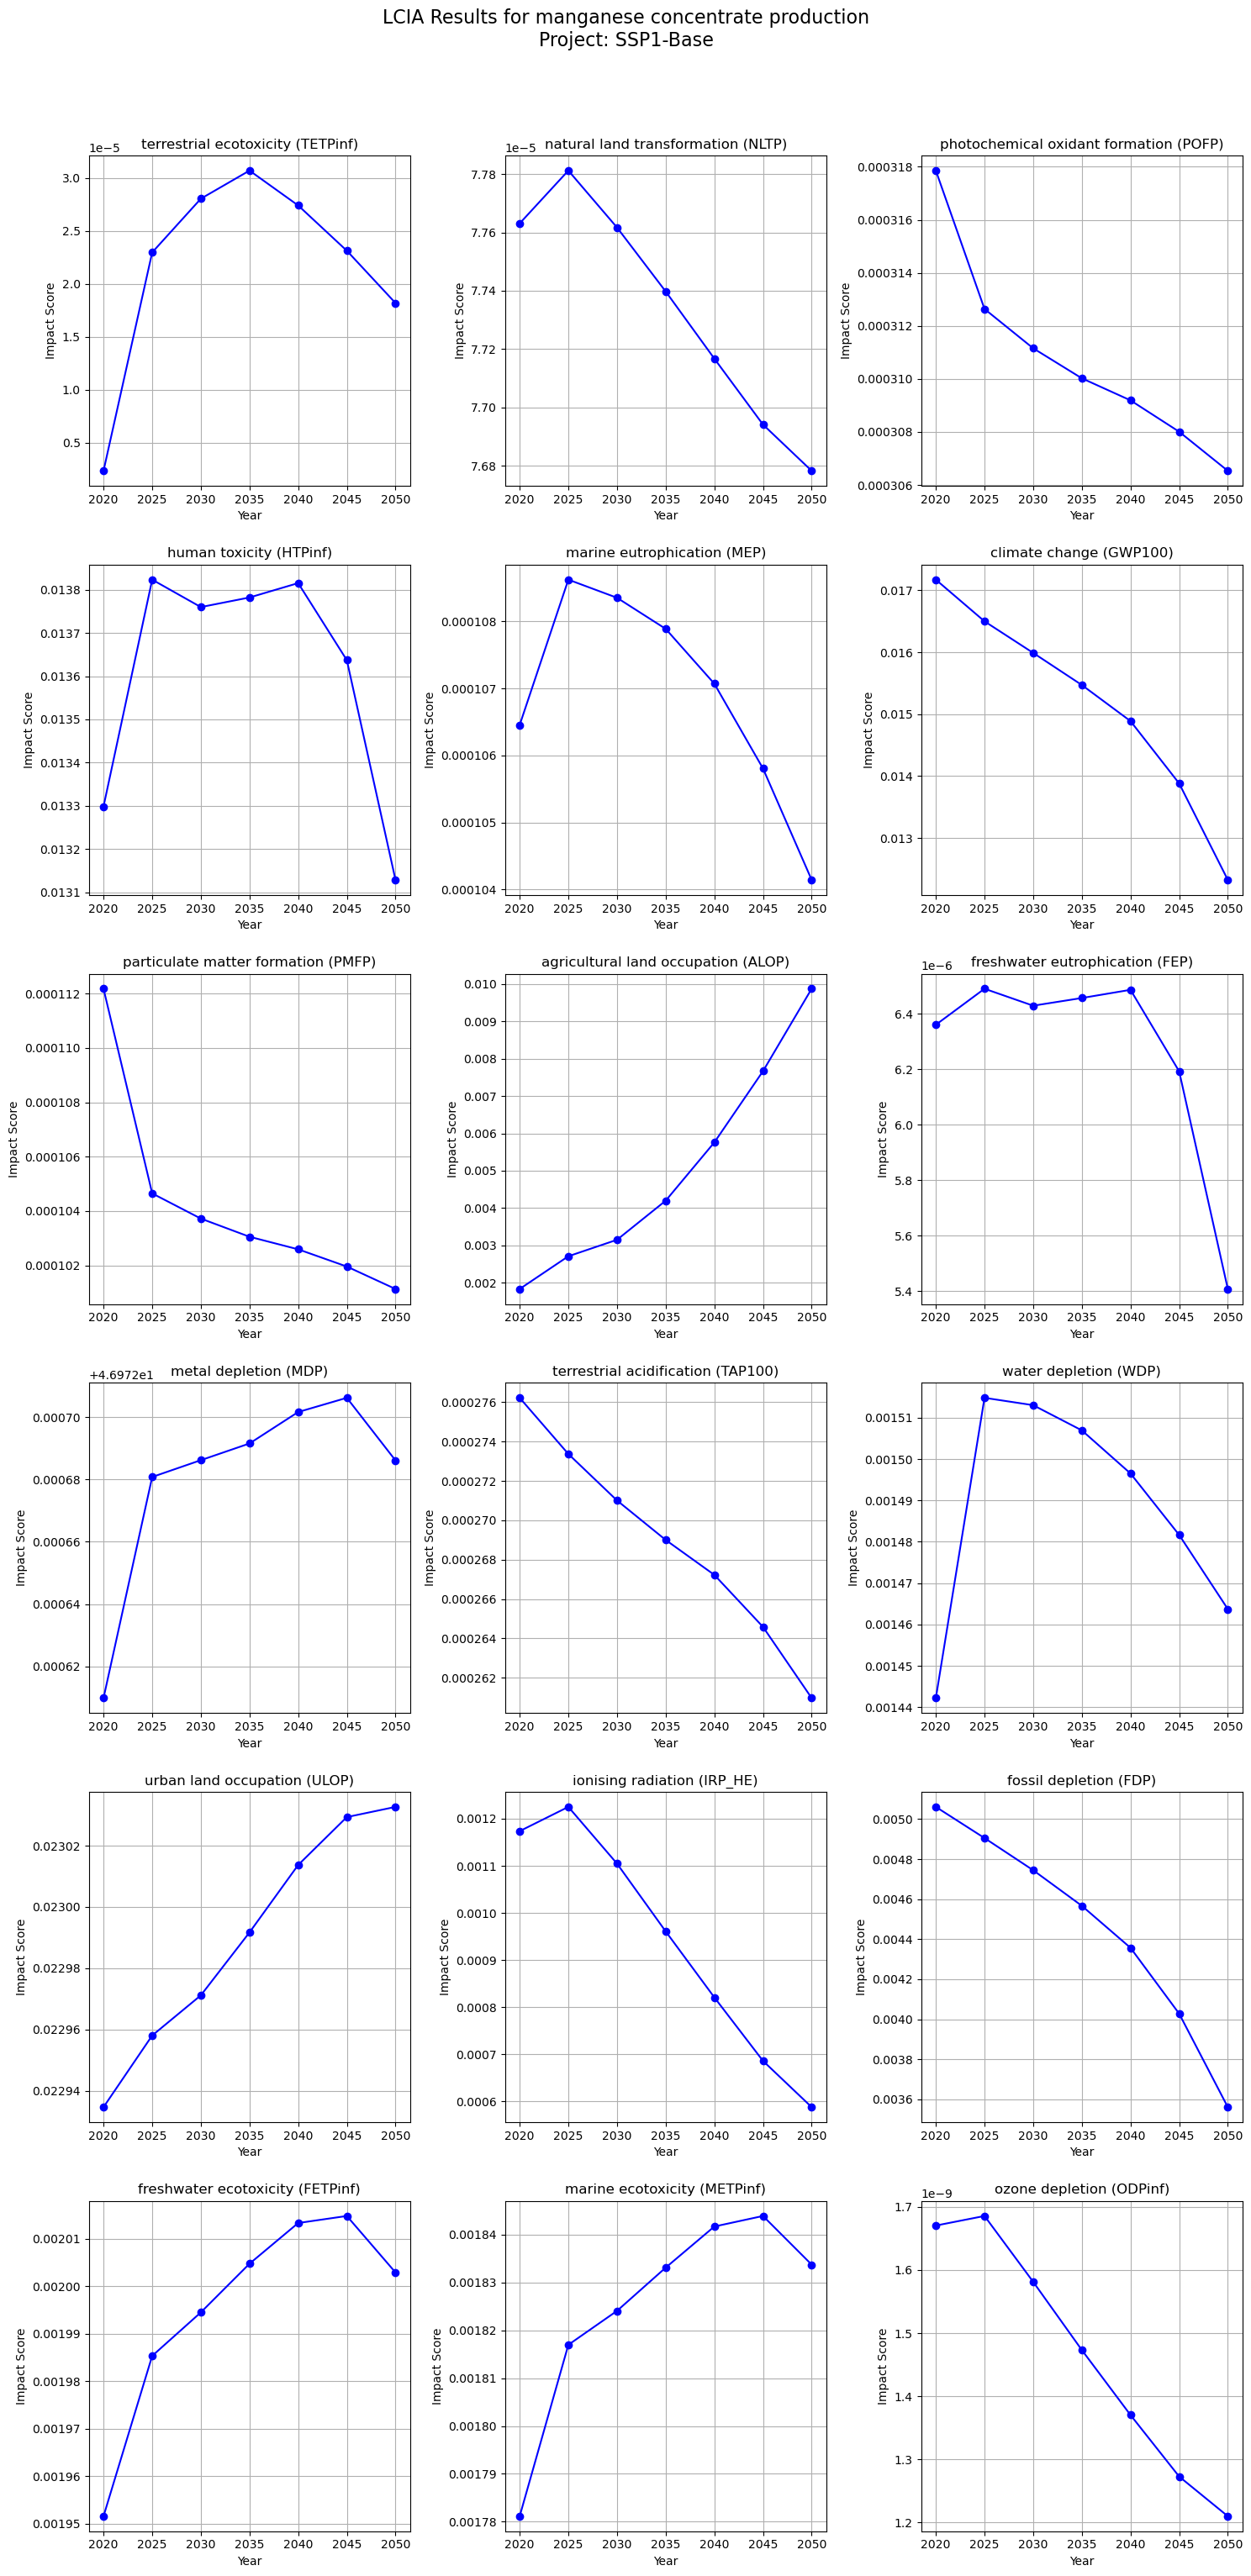

In [55]:
plot_combined_lcia_results_across_years(lcia_results_per_year, recipe_midpoint_h, activity_name, "SSP1-Base (Electricity Updated)")

### 5.1.1. Manganese dioxide production

In [41]:
# Search term from updated SSP1-Base2020 database.
# Updated from:
## Source: Jarod C. Kelly, Michael Wang, Qiang Dai, Olumide Winjobi, Energy, greenhouse gas, and water life cycle analysis of lithium carbonate and lithium hydroxide monohydrate from brine and ore resources and their use in lithium ion battery cathodes and lithium ion batteries, Resources, Conservation and Recycling, Volume 174, 2021, 105762, ISSN 0921-3449, https://doi.org/10.1016/j.resconrec.2021.105762.
activity_name = 'manganese dioxide production'

In [42]:
# Run the LCIA across all years
lcia_results_per_year = run_lcia_across_years(activity_name, recipe_midpoint_h, databases_remindSSP1_energy)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.0002594014011462738
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.0005737406544681415
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.007399895104447995
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 5.5314531130461155
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.002270759694337099
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 2.508523389649353
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.0037974088529873634
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.16677620988154337
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.0012637645088863139
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 91.3291376327445
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.012452137156690071
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.012573479122980605
('ReCiPe Midpoint (H)', 'urban land occ

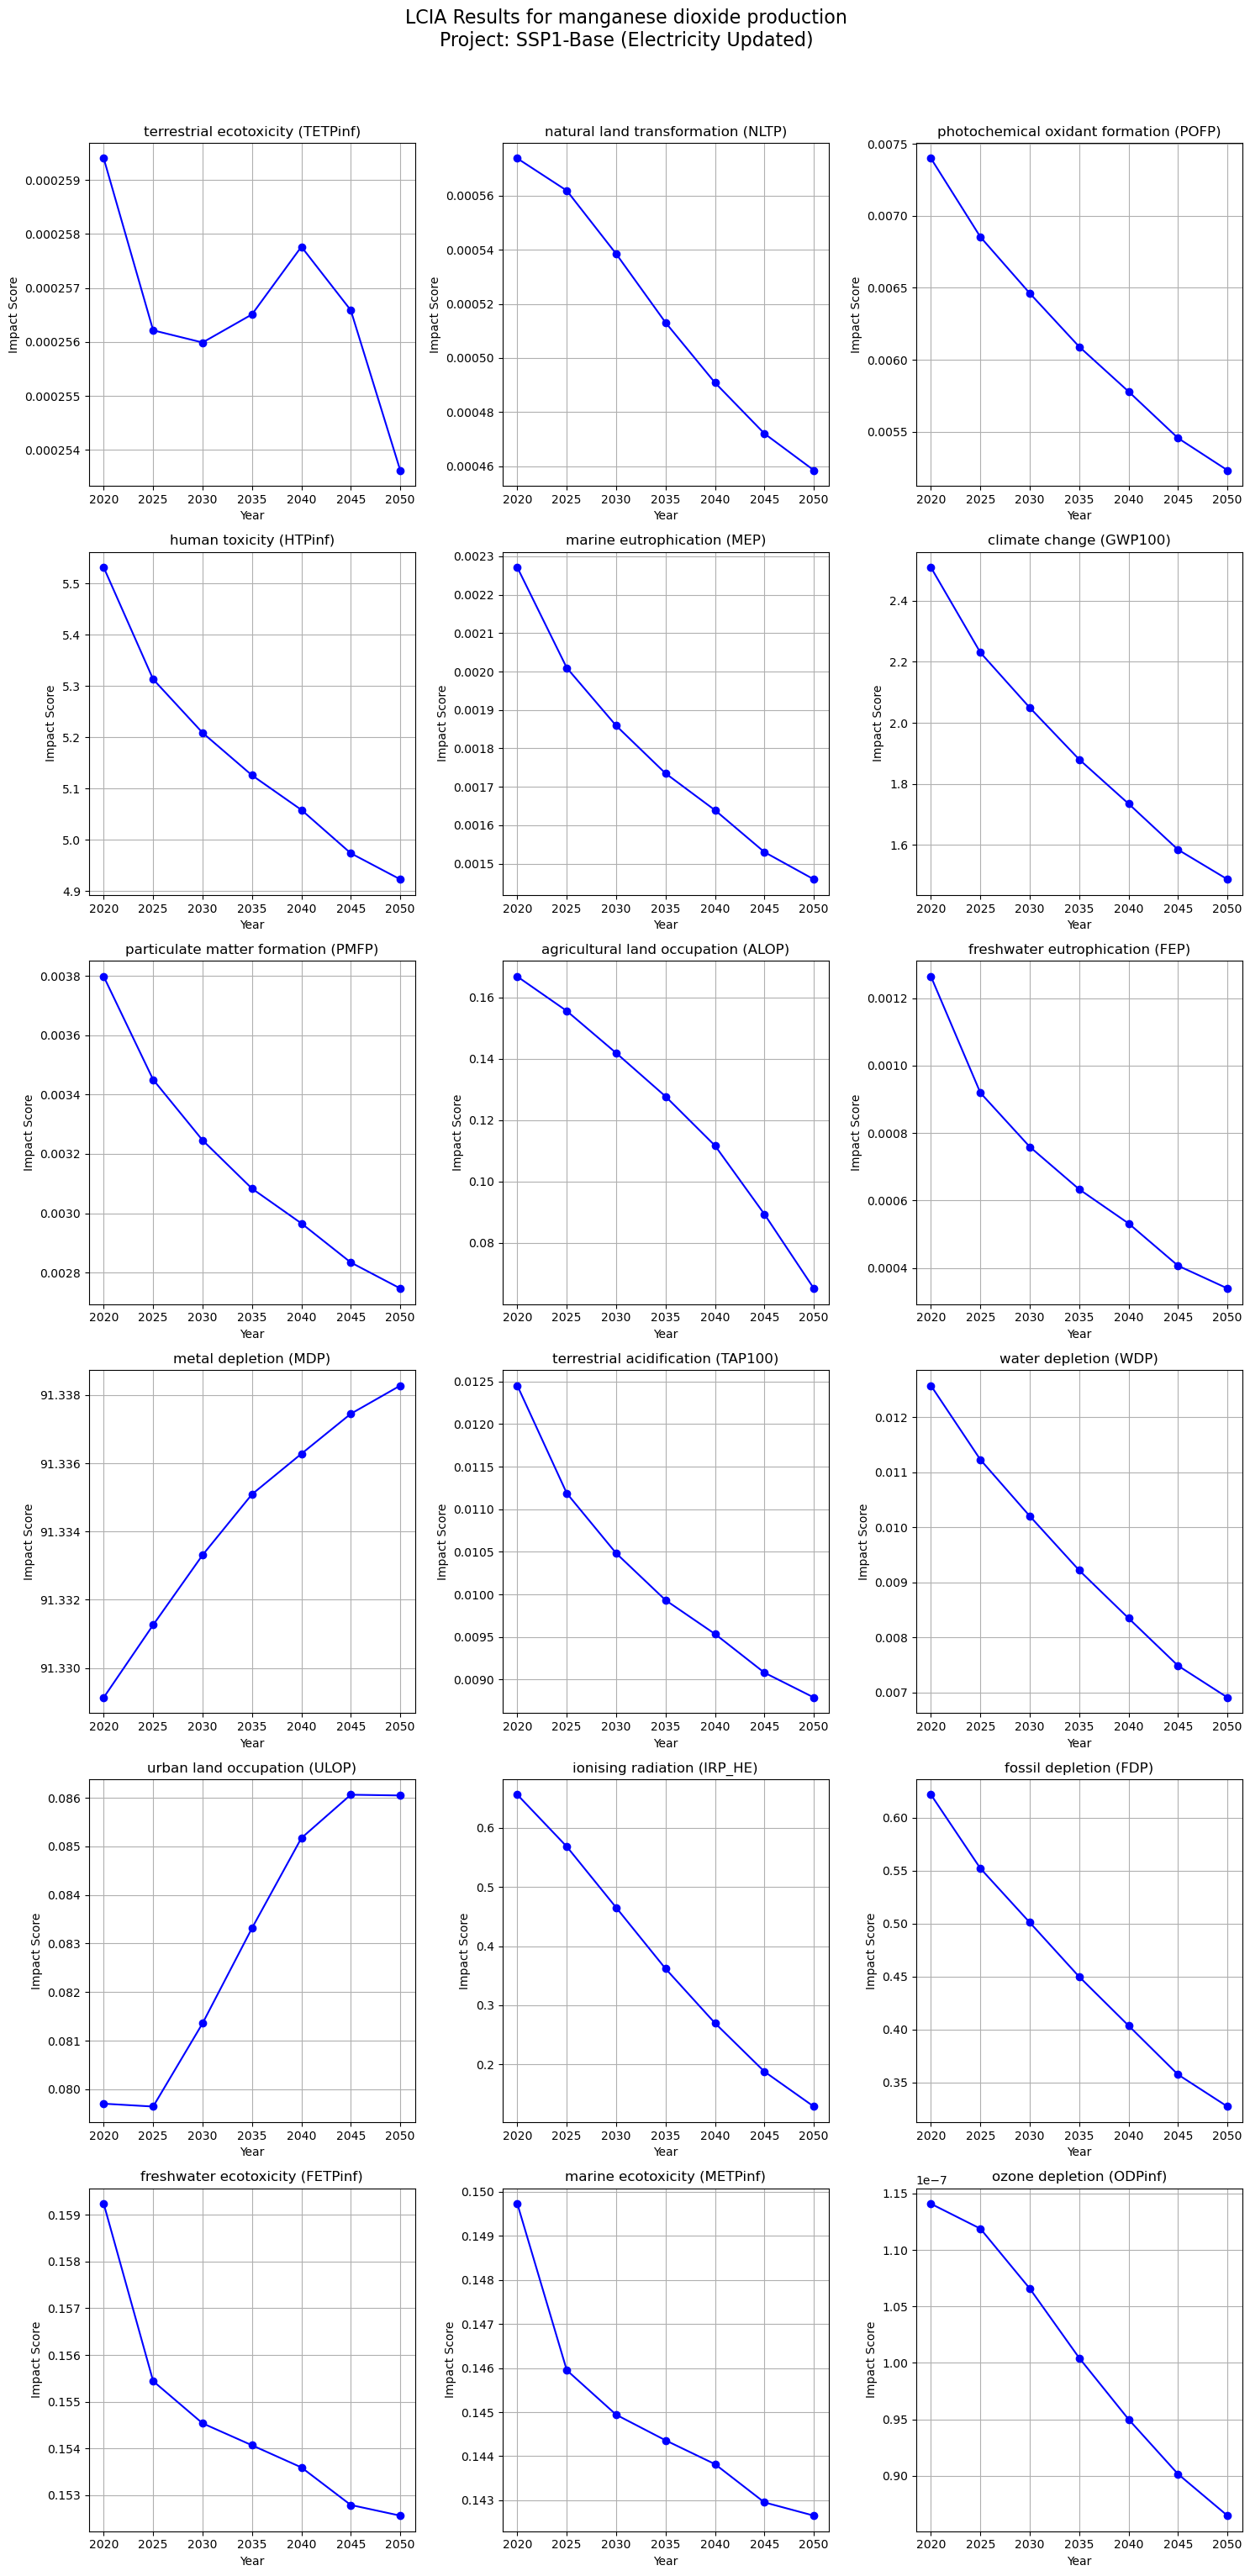

In [43]:
plot_combined_lcia_results_across_years(lcia_results_per_year, recipe_midpoint_h, activity_name, "SSP1-Base (Electricity Updated)")

### 5.1.1. Manganese sulfate production

In [44]:
# Search term from updated SSP1-Base2020 database.
# Updated from:
## Source: Jarod C. Kelly, Michael Wang, Qiang Dai, Olumide Winjobi, Energy, greenhouse gas, and water life cycle analysis of lithium carbonate and lithium hydroxide monohydrate from brine and ore resources and their use in lithium ion battery cathodes and lithium ion batteries, Resources, Conservation and Recycling, Volume 174, 2021, 105762, ISSN 0921-3449, https://doi.org/10.1016/j.resconrec.2021.105762.
activity_name = 'manganese sulfate production'

In [45]:
# Run the LCIA across all years
lcia_results_per_year = run_lcia_across_years(activity_name, recipe_midpoint_h, databases_remindSSP1_energy)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 8.673664309784545e-05
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.00026798105979081426
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.0043495129172339535
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 1.8566430776228389
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.0007960761623202155
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 0.6895572499200766
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.005330408525536595
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.045106077671415654
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.00032298485388694944
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 42.682555684630756
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.024083115547219446
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.005665842241040947
('ReCiPe Midpoint (H)', 'urban l

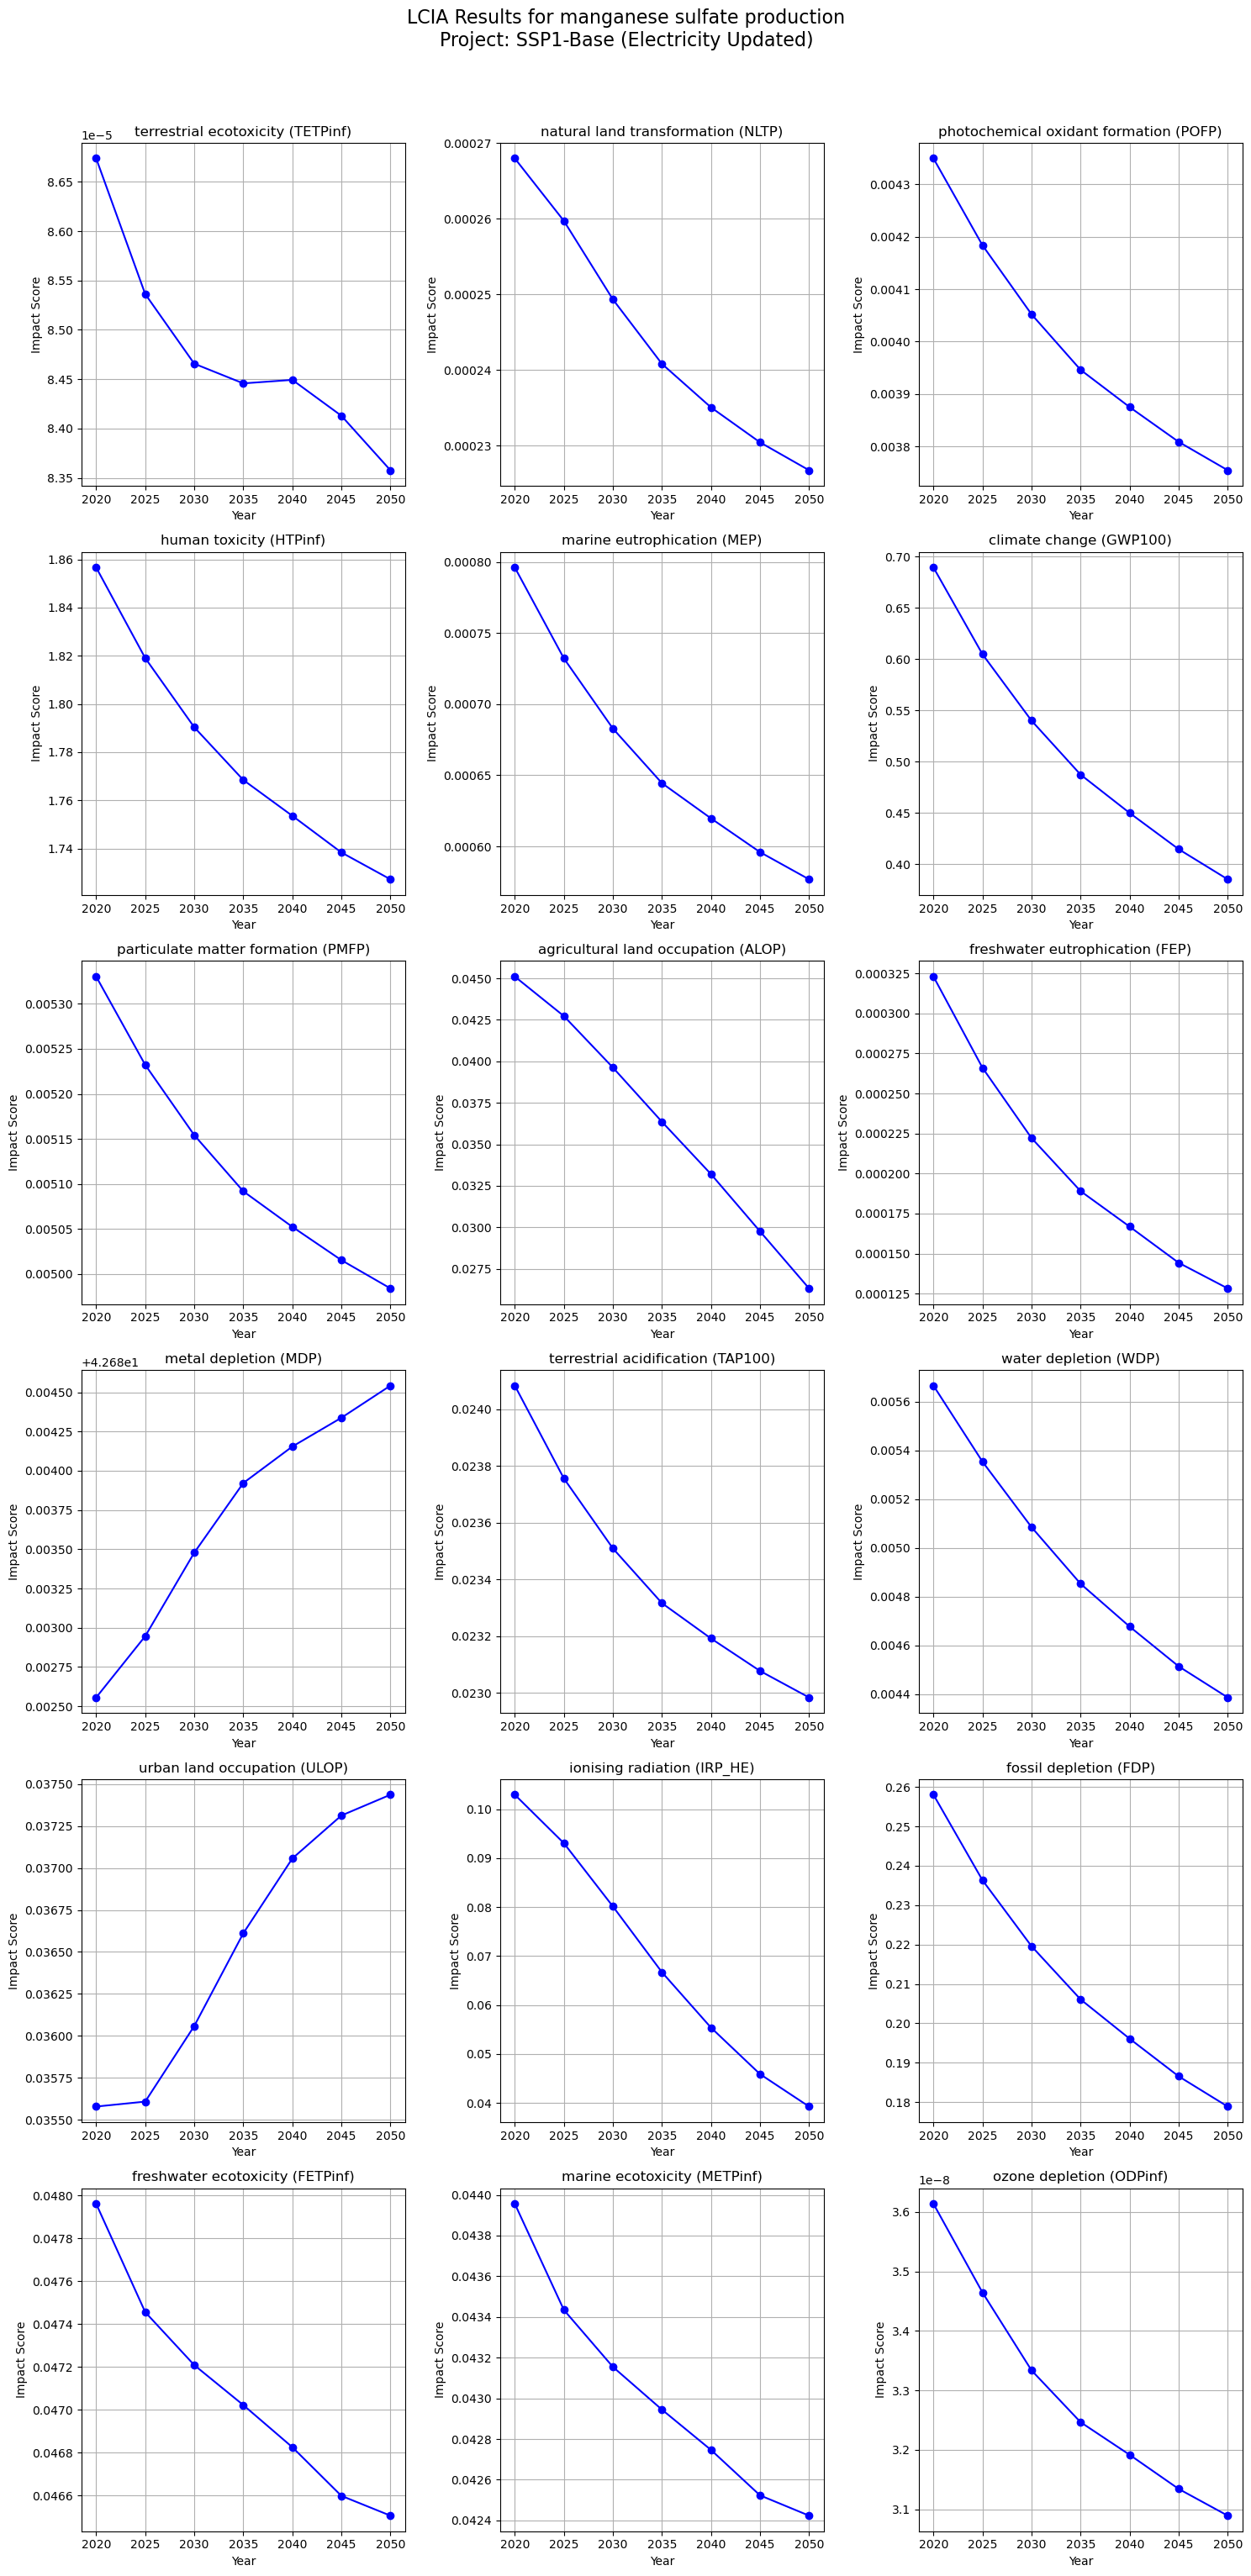

In [46]:
plot_combined_lcia_results_across_years(lcia_results_per_year, recipe_midpoint_h, activity_name, "SSP1-Base (Electricity Updated)")

## 5.2. All compared across years

In [47]:
# Run LCIA for all activities across all years
lcia_results_all_activities = run_lcia_for_multiple_activities(activities_mn, recipe_midpoint_h, databases_remindSSP1_energy)

Processing activity: manganese dioxide production
('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.0002594014011462738
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.0005737406544681415
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.007399895104447995
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 5.5314531130461155
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.002270759694337099
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 2.508523389649353
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.0037974088529873634
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.16677620988154337
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.0012637645088863139
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 91.3291376327445
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.012452137156690071
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.01257347

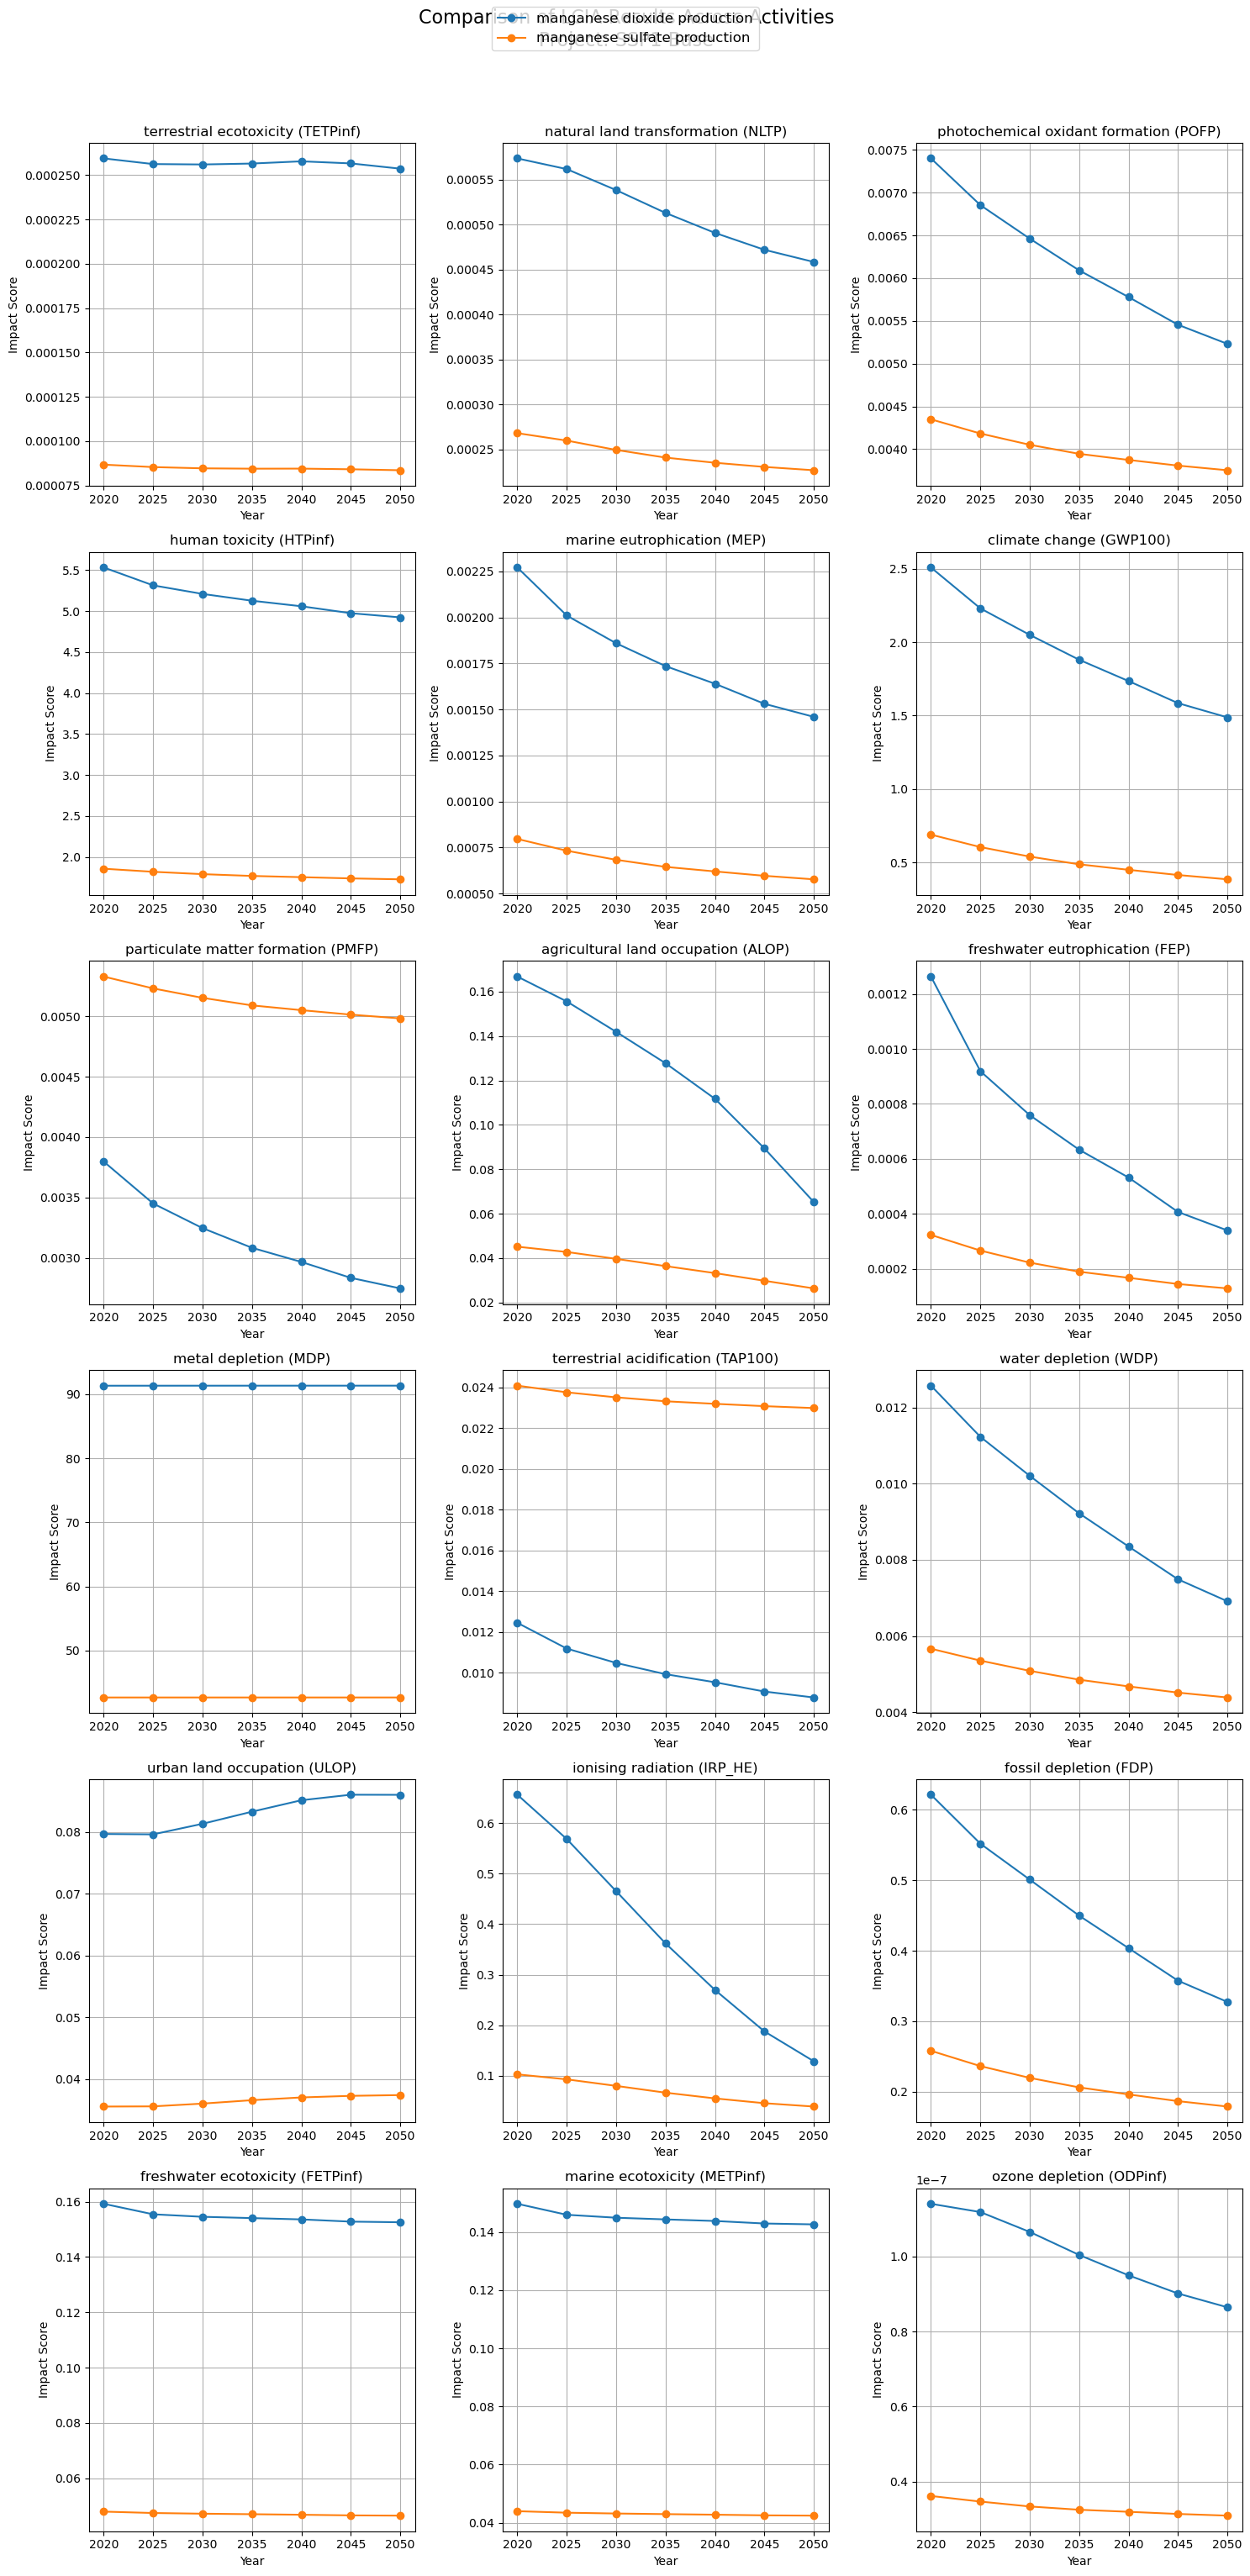

In [48]:
# Plot comparison of results across activities
plot_comparison_across_activities(lcia_results_all_activities, recipe_midpoint_h, activities_mn)

# 6. Cobalt

# 7. battery cell, NMC-811

In [49]:
activity_name = 'battery cell, NMC-811'

In [50]:
# Run the LCIA across all years
lcia_results_per_year = run_lcia_across_years(activity_name, recipe_midpoint_h, databases_remindSSP1_energy)

('ReCiPe Midpoint (H)', 'terrestrial ecotoxicity', 'TETPinf'): 0.0073372264166037034
('ReCiPe Midpoint (H)', 'natural land transformation', 'NLTP'): 0.0039051695299620183
('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'): 0.05593353813027657
('ReCiPe Midpoint (H)', 'human toxicity', 'HTPinf'): 31.653457763447307
('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP'): 0.016107097338121563
('ReCiPe Midpoint (H)', 'climate change', 'GWP100'): 13.666796194680863
('ReCiPe Midpoint (H)', 'particulate matter formation', 'PMFP'): 0.04877683568617414
('ReCiPe Midpoint (H)', 'agricultural land occupation', 'ALOP'): 0.630276430548725
('ReCiPe Midpoint (H)', 'freshwater eutrophication', 'FEP'): 0.011610476315997336
('ReCiPe Midpoint (H)', 'metal depletion', 'MDP'): 25.27172172308701
('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'): 0.15416577511171975
('ReCiPe Midpoint (H)', 'water depletion', 'WDP'): 0.1343452695340673
('ReCiPe Midpoint (H)', 'urban land occupation

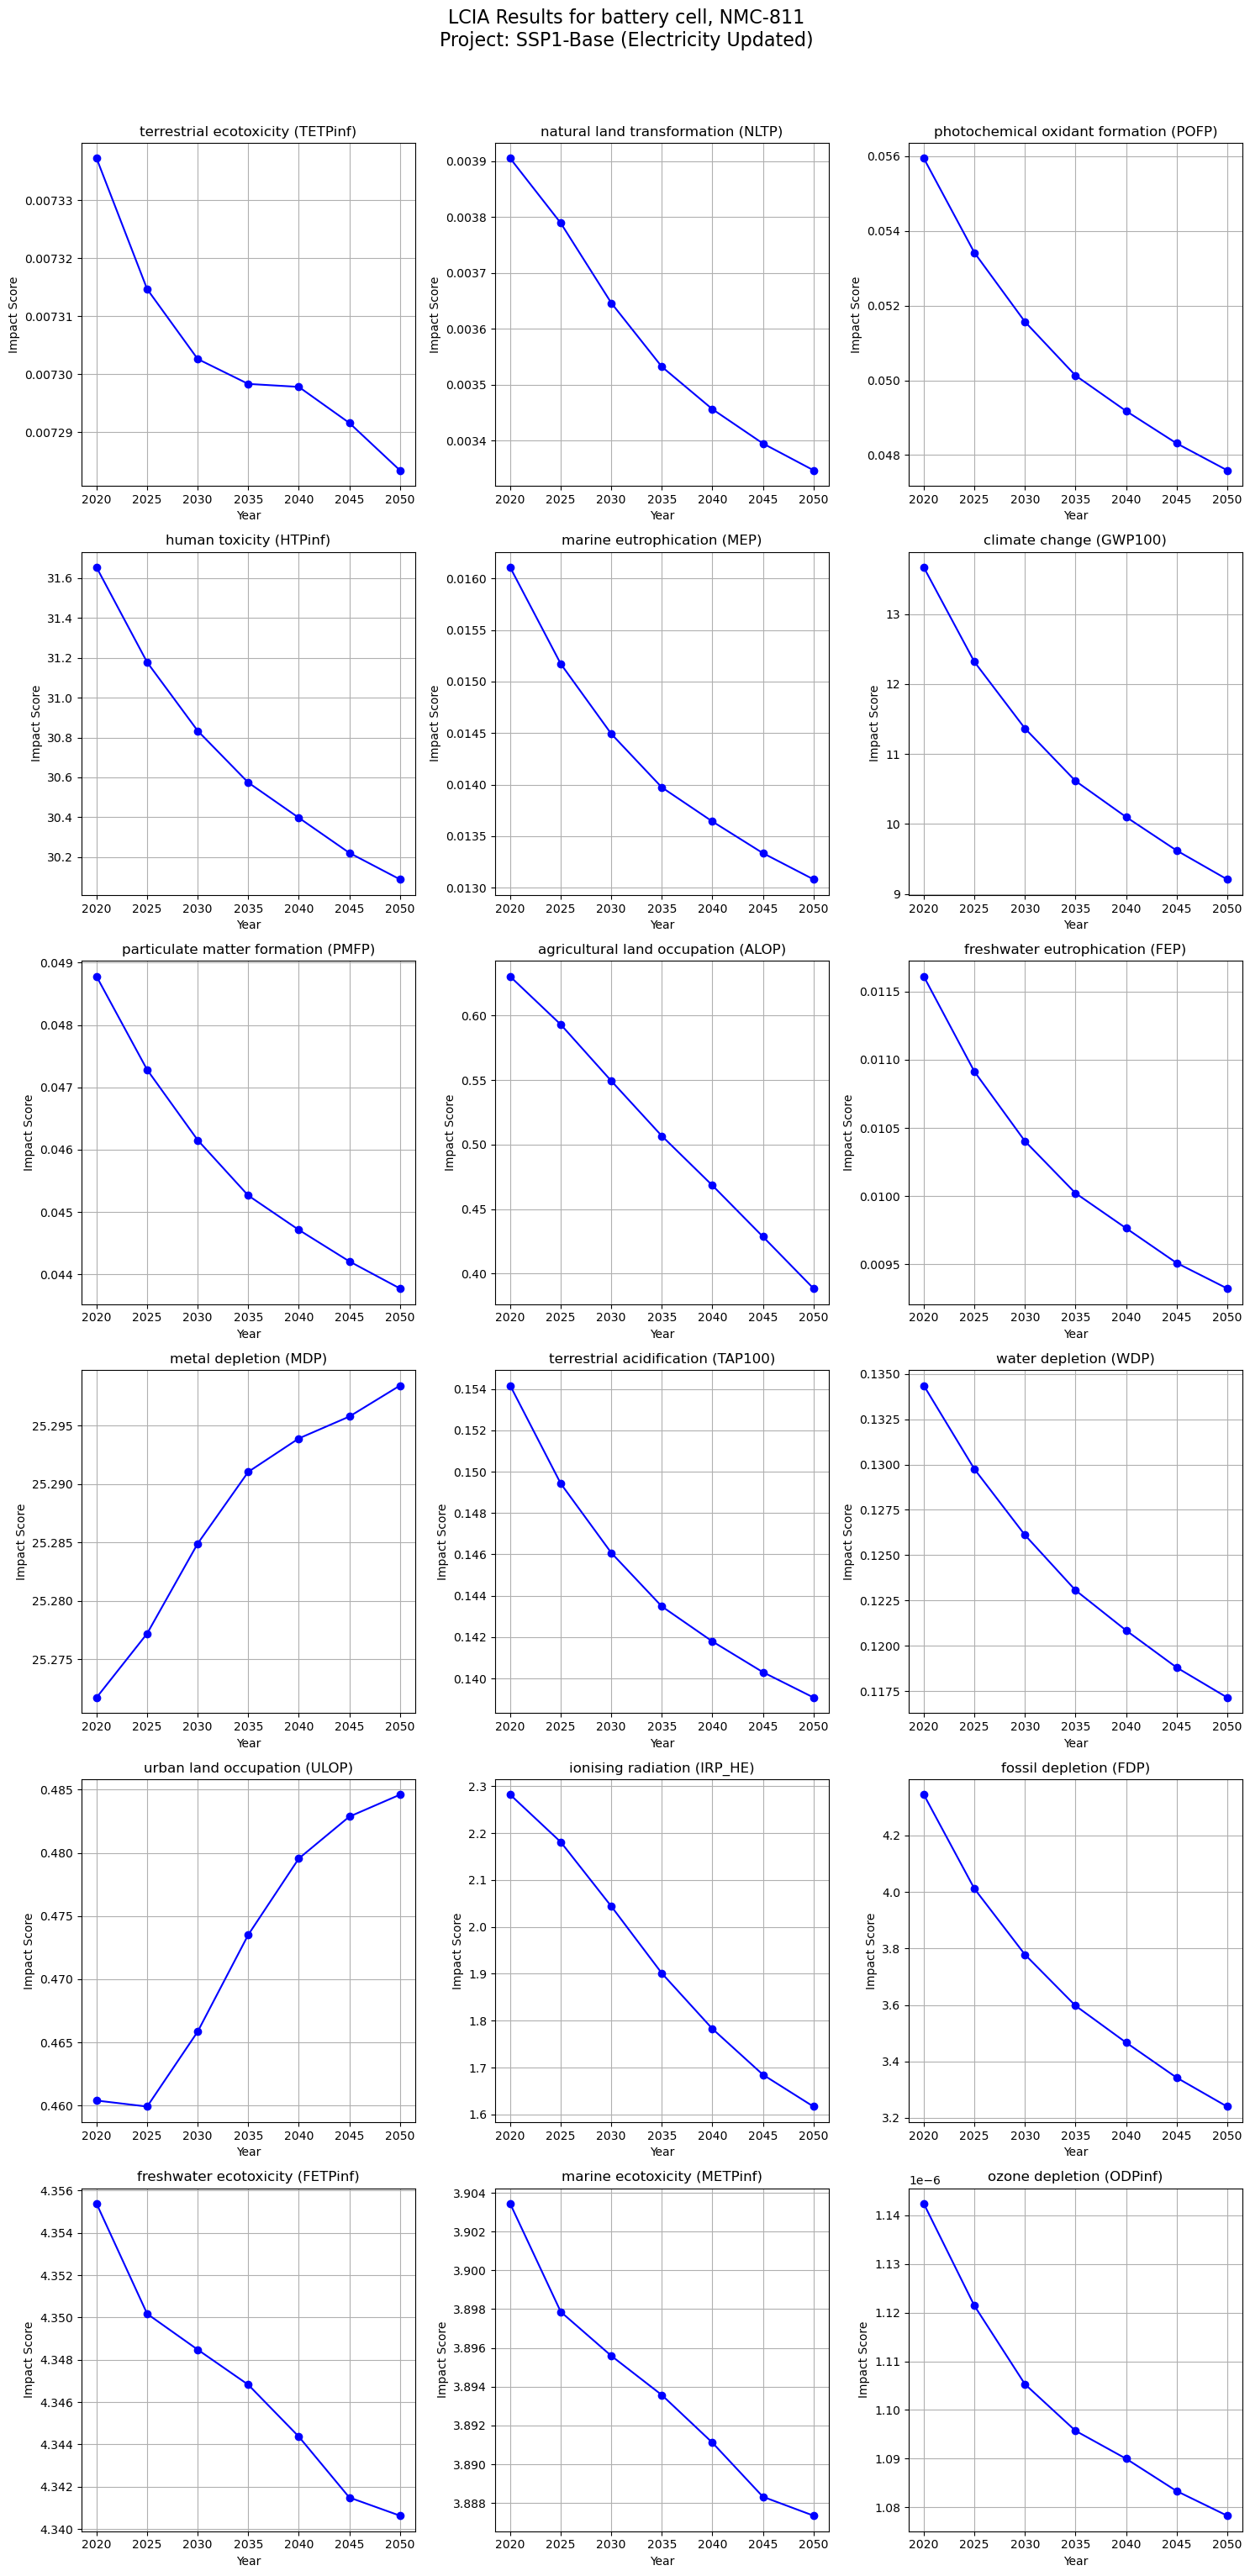

In [51]:
plot_combined_lcia_results_across_years(lcia_results_per_year, recipe_midpoint_h, activity_name, "SSP1-Base (Electricity Updated)")

# 8. Export of technosphere exchanges